# Analysis with python notebook of all results

Steps:

1. Collect all results of the simulation on a python readable file, having done reblocking before

2. Analyze molecules, QMC versus DFT 

3. Analyze dimers binding energies \
    a. Preliminary plots in FIG03 \
    b. Do extrapolations w/ w/o Jopt on molecules & comparison with CCSD(T) results \
    c. Define gold, silver, bronze schemes, and their cost

4. Compare binding energies with other references 

5. Tool to predict QMC cost \
    a. Multilinear fit of the variance \
    b. Use of Student's t distribution to estimate cost 

6. Plots for some relevant cases

7. Plots for the paper


In [9]:
import os
import re
import math
import pickle
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from def_colors import map_DMC, dmc_color, dft_color

from define_setup import *

# Read mol_info
with open( 'mol_info.pkl', 'rb' ) as f:
    mol_info = pickle.load( f )
#mol_info

df_mol_info = pd.read_csv( 'mol_info.csv', index_col=0 )
df_mol_info

# Read results monomer
with open( dir_analysis+'results_mol.pkl', 'rb' ) as f:
    results_mol = pickle.load( f )

# Read mol_info
with open( 'dim_info.pkl', 'rb' ) as f:
    dim_info = pickle.load( f )

dim_info

with open( dir_analysis+'results_dim.pkl', 'rb' ) as f:
    results_dim = pickle.load( f )


In [10]:
df_refs = pd.read_csv( 'Refs.csv', index_col=0 )
df_refs

name  Hobza_1  Hobza_2  Martin_newBronze  Martin_Silver  \
1       01 Water-Water    -4.92    -5.01            -4.915         -4.982   
2        02 Water-MeOH    -5.59    -5.70            -5.589         -5.666   
3       03 Water-MeNH2    -6.91    -7.04            -6.894         -6.986   
4     04 Water-Peptide    -8.10    -8.22            -8.089         -8.183   
5         05 MeOH-MeOH    -5.76    -5.85            -5.773         -5.822   
..                 ...      ...      ...               ...            ...   
62    62 Pentane-AcNH2    -3.53    -3.53            -3.458         -3.491   
63     63 Benzene-AcOH    -3.80    -3.75            -3.715         -3.709   
64   64 Peptide-Ethene    -3.00    -3.00            -2.945         -2.967   
65  65 Pyridine-Ethyne    -3.99    -4.10            -4.065         -4.064   
66   66 MeNH2-Pyridine    -3.97    -3.97            -3.907         -3.930   

    Martin_Gold  Martin_PCCP2022  14k-Gold  
1        -4.979           -4.946    -4.991  
2        -5.666           -5.627    -5.674  
3        -6.985           -6.941    -6.996  
4           NaN           -8.128    -8.191  
5        -5.824           -5.804    -5.827  
..          ...              ...       ...  
62          NaN           -3.437    -3.495  
63          NaN           -3.671    -3.716  
64          NaN           -2.928    -2.977  
65          NaN           -4.066    -4.071  
66          NaN           -3.893    -3.931  

[66 rows x 8 columns]

In [11]:
# Reading the evaluation in 03a_* 
# of DMC binding energies of all dimers, i=1,...,66, 
# into a Pamdas DataFrame, reporting Eb, error, dmc_type, dmc_Jas, name, ...
# Final DataFrame is obtained from the concatenation of individual dataframes,
# each for a different dimer and a different DMC setup


Edimer = pd.read_csv('Edimer.csv', index_col=0)

Eb = pd.read_csv('Eb.csv', index_col=0)

Eb_1ref = pd.read_csv('Eb_1ref.csv', index_col=0)

Eb

ene       err               name   i dmc_type   Jas Jas_mol  \
0   -2.466741  0.046796     01_Water-Water   1   DMCtm5  Jopt  JoptLA   
1   -2.962955  0.037100     01_Water-Water   1   DMCtm5  Jopt  JoptLA   
2   -3.599663  0.032754     01_Water-Water   1   DMCtm5  Jopt  JoptLA   
3   -4.285075  0.035724     01_Water-Water   1   DMCtm5  Jopt  JoptLA   
4   -4.197201  0.185923     01_Water-Water   1   DMCtm5  Jopt  JoptLA   
..        ...       ...                ...  ..      ...   ...     ...   
444 -3.976514  0.048291  66_MeNH2-Pyridine  66  DMCdla5  Jopt    Jopt   
445 -3.995998  0.064844  66_MeNH2-Pyridine  66  DMCdla5  Jopt    Jopt   
446 -3.625580  0.063502  66_MeNH2-Pyridine  66  DMCdla5  Jopt  Jdimer   
447 -3.938631  0.049563  66_MeNH2-Pyridine  66  DMCdla5  Jopt  Jdimer   
448 -3.906021  0.064765  66_MeNH2-Pyridine  66  DMCdla5  Jopt  Jdimer   

        delta    tau  
0    0.030971  0.100  
1    0.030971  0.060  
2    0.030971  0.030  
3    0.030971  0.010  
4    0.030971  0.006  
..        ...    ...  
444  0.001287  0.030  
445  0.001287  0.010  
446  0.001287  0.100  
447  0.001287  0.030  
448  0.001287  0.010  

[449 rows x 9 columns]

In [12]:
d = Edimer[ Edimer['i']==1 ]
d.loc[ d['tau'] <= 0.03, : ]

ene       err     units  TotTimeSim[au]           Pop   Pop-err  \
2  -21593.206610  0.019761  kcal/mol          1215.0  63953.916472  0.655075   
3  -21593.902714  0.022036  kcal/mol          1005.0  63984.356412  0.414554   
4  -21594.285384  0.024074  kcal/mol           777.0  63982.548927  0.363725   
5  -21594.598270  0.038373  kcal/mol           388.5  64011.054103  0.368187   
7  -21594.742661  0.021172  kcal/mol          1215.0  63898.234203  0.615966   
8  -21594.575269  0.022685  kcal/mol          1010.0  63929.393700  0.567137   
9  -21594.658280  0.020500  kcal/mol          1005.0  63963.003226  0.419906   
12 -21604.400931  0.023147  kcal/mol          1215.0  63980.995992  0.650140   
13 -21603.920124  0.026118  kcal/mol          1005.0  63980.922010  0.433089   
14 -21603.974571  0.025260  kcal/mol          1201.5  63994.582792  0.219845   
15 -21604.034267  0.024686  kcal/mol          1000.5  63991.396458  0.141569   

     Var[au]  tau_eff[au]  corr-time[au]  \
2   0.552120     0.028862       0.131564   
3   0.540201     0.009906       0.125939   
4   0.535780     0.005972       0.135900   
5   0.534968     0.002994       0.124343   
7   0.572748     0.028863       0.134879   
8   0.552755     0.019541       0.126479   
9   0.548701     0.009906       0.117862   
12  0.523861     0.028883       0.180863   
13  0.537514     0.009908       0.196763   
14  0.540806     0.002995       0.178317   
15  0.531294     0.001000       0.168011   

                                      machine  N_MPI      cost  target_weight  \
2          linuxpc-intel-slurm-parallel.peta4   64.0  0.902262        64000.0   
3          linuxpc-intel-slurm-parallel.peta4   64.0  0.883902        64000.0   
4                                         NaN    NaN       NaN            NaN   
5                                         NaN    NaN       NaN            NaN   
7          linuxpc-intel-slurm-parallel.peta4   64.0  0.892656        64000.0   
8          linuxpc-intel-slurm-parallel.peta4   64.0  0.916368        64000.0   
9          linuxpc-intel-slurm-parallel.peta4   64.0  0.891023        64000.0   
12         linuxpc-intel-slurm-parallel.peta4  128.0  0.275161        64000.0   
13         linuxpc-intel-slurm-parallel.peta4  128.0  0.273290        64000.0   
14         linuxpc-intel-slurm-parallel.peta4  960.0  0.079150        64000.0   
15  linuxpc-intel-slurm-parallel.peta4-cclake  112.0  0.333377        64000.0   

      tau            name  i dmc_type   Jas  Nelv  
2   0.030  01_Water-Water  1   DMCtm5  Jopt    16  
3   0.010  01_Water-Water  1   DMCtm5  Jopt    16  
4   0.006  01_Water-Water  1   DMCtm5  Jopt    16  
5   0.003  01_Water-Water  1   DMCtm5  Jopt    16  
7   0.030  01_Water-Water  1   DMCtm5  Jopt    16  
8   0.020  01_Water-Water  1   DMCtm5  Jopt    16  
9   0.010  01_Water-Water  1   DMCtm5  Jopt    16  
12  0.030  01_Water-Water  1  DMCdla5  Jopt    16  
13  0.010  01_Water-Water  1  DMCdla5  Jopt    16  
14  0.003  01_Water-Water  1  DMCdla5  Jopt    16  
15  0.001  01_Water-Water  1  DMCdla5  Jopt    16

In [13]:
from scipy.optimize import curve_fit

def fun_lin( x, a, b ):
    return a + b * x
def fun_quad( x, a, b, c ):
    return a + b * x + c * x**2


1 01_Water-Water
{'DMCtm5', 'DMCdla5'}
1 DMCtm5
1 DMCdla5
2 02_Water-MeOH
{'DMCdla5'}
2 DMCdla5


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


3 03_Water-MeNH2
{'DMCdla5'}
3 DMCdla5
4 04_Water-Peptide
{'DMCdla5'}
4 DMCdla5


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


5 05_MeOH-MeOH
{'DMCdla5'}
5 DMCdla5
6 06_MeOH-MeNH2
{'DMCdla5'}
6 DMCdla5


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


7 07_MeOH-Peptide
{'DMCdla5'}
7 DMCdla5
8 08_MeOH-Water
{'DMCdla5'}
8 DMCdla5
9 09_MeNH2-MeOH
{'DMCdla5'}

/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',



9 DMCdla5
10 10_MeNH2-MeNH2
{'DMCdla5'}
10 DMCdla5
11 11_MeNH2-Peptide
{'DMCdla5'}
11 DMCdla5
12 12_MeNH2-Water
{'DMCdla5'}
12 DMCdla5
13 13_Peptide-MeOH
{'DMCdla5'}
13 DMCdla5
14 14_Peptide-MeNH2
{'DMCdla5'}
14 DMCdla5
15 15_Peptide-Peptide
{'DMCdla5'}
15 DMCdla5
16 16_Peptide-Water
{'DMCdla5'}
16 DMCdla5
17 17_Uracil-Uracil_BP
{'DMCdla5'}
17 DMCdla5
18 18_Water-Pyridine
{'DMCdla5'}
18 DMCdla5
19 19_MeOH-Pyridine
{'DMCdla5'}
19 DMCdla5
20 20_AcOH-AcOH
{'DMCtm5', 'DMCdla5'}
20 DMCtm5
20 DMCdla5
21 21_AcNH2-AcNH2
{'DMCdla5'}
21 DMCdla5


<ipython-input-14-a28888430a23>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots() #figsize=(10, 5) )


22 22_AcOH-Uracil
{'DMCdla5'}
22 DMCdla5
23 23_AcNH2-Uracil
{'DMCdla5'}
23 DMCdla5
24 24_Benzene-Benzene_pi-pi
{'DMCdla5'}
24 DMCdla5
25 25_Pyridine-Pyridine_pi-pi
{'DMCdla', 'DMCdla5', 'DMC'}
25 DMCdla
25 DMCdla5
25 DMC
26 26_Uracil-Uracil_pi-pi
{'DMCdla', 'DMCdla5'}
26 DMCdla
26 DMCdla5
27 27_Benzene-Pyridine_pi-pi
{'DMCdla5'}
27 DMCdla5
28 28_Benzene-Uracil_pi-pi
{'DMCdla5'}
28 DMCdla5


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


29 29_Pyridine-Uracil_pi-pi
{'DMCdla5'}
29 DMCdla5
30 30_Benzene-Ethene
{'DMCdla5'}
30 DMCdla5


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


31 31_Uracil-Ethene
{'DMCdla5'}
31 DMCdla5
32 32_Uracil-Ethyne
{'DMCdla5'}
32 DMCdla5


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


33 33_Pyridine-Ethene
{'DMCdla5'}
33 DMCdla5
34 34_Pentane-Pentane
{'DMCdla5'}
34 DMCdla5


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


35 35_Neopentane-Pentane
{'DMCdla5'}
35 DMCdla5
36 36_Neopentane-Neopentane
{'DMCdla5'}
36 DMCdla5


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


37 37_Cyclopentane-Neopentane
{'DMCdla5'}
37 DMCdla5
38 38_Cyclopentane-Cyclopentane
{'DMCdla5'}
38 DMCdla5
39 39_Benzene-Cyclopentane
{'DMCdla5'}
39 DMCdla5
40 40_Benzene-Neopentane
{'DMCdla5'}
40 DMCdla5
41 41_Uracil-Pentane
{'DMCdla5'}
41 DMCdla5
42 42_Uracil-Cyclopentane
{'DMCdla5'}
42 DMCdla5


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


43 43_Uracil-Neopentane
{'DMCdla5'}
43 DMCdla5
44 44_Ethene-Pentane
{'DMCdla5'}
44 DMCdla5


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


45 45_Ethyne-Pentane
{'DMCdla5'}
45 DMCdla5
46 46_Peptide-Pentane
{'DMCdla5'}
46 DMCdla5


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


47 47_Benzene-Benzene_TS
{'DMCdla5'}
47 DMCdla5
48 48_Pyridine-Pyridine_TS
{'DMCdla5'}
48 DMCdla5
49 49_Benzene-Pyridine_TS
{'DMCdla5'}
49 DMCdla5
50 50_Benzene-Ethyne_CH-pi
{'DMCdla5'}
50 DMCdla5
51 51_Ethyne-Ethyne_TS


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


{'DMCdla5'}
51 DMCdla5
52 52_Benzene-AcOH_OH-pi
{'DMCdla5'}
52 DMCdla5
53 53_Benzene-AcNH2_NH-pi
{'DMCdla5'}
53 DMCdla5
54 54_Benzene-Water_OH-pi
{'DMCdla5'}
54 DMCdla5
55 55_Benzene-MeOH_OH-pi
{'DMCdla5'}
55 DMCdla5
56 56_Benzene-MeNH2_NH-pi
{'DMCdla5'}
56 DMCdla5
57 57_Benzene-Peptide_NH-pi
{'DMCdla5'}
57 DMCdla5
58 58_Pyridine-Pyridine_CH-N
{'DMCdla5'}
58 DMCdla5
59 59_Ethyne-Water_CH-O
{'DMCdla5'}
59 DMCdla5
60 60_Ethyne-AcOH_OH-pi
{'DMCdla5'}
60 DMCdla5
61 61_Pentane-AcOH
{'DMCdla5'}
61 DMCdla5
62 62_Pentane-AcNH2
{'DMCdla5'}
62 DMCdla5
63 63_Benzene-AcOH


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


{'DMCdla5'}
63 DMCdla5
64 64_Peptide-Ethene
{'DMCdla5'}
64 DMCdla5
65 65_Pyridine-Ethyne


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


{'DMCdla5'}
65 DMCdla5
66 66_MeNH2-Pyridine
{'DMCdla5'}
66 DMCdla5


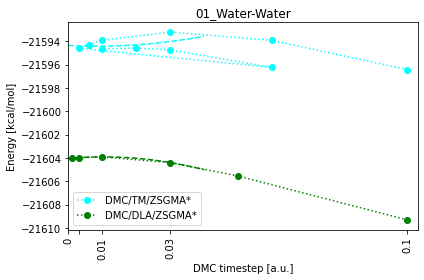

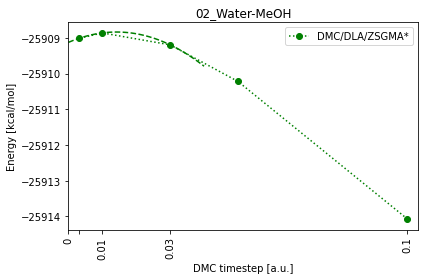

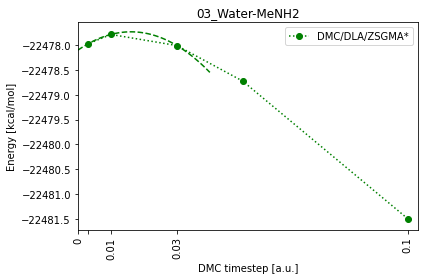

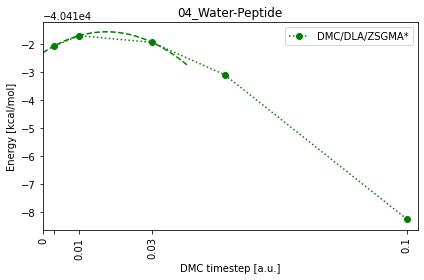

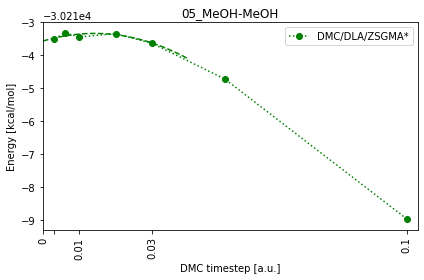

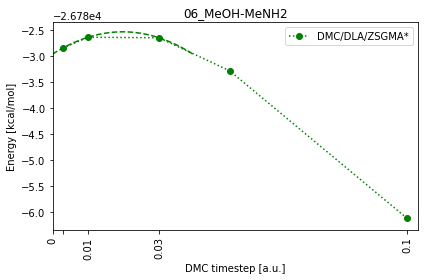

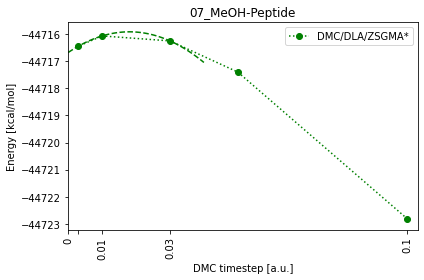

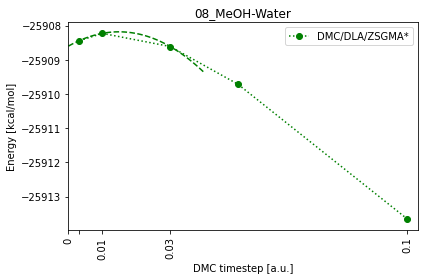

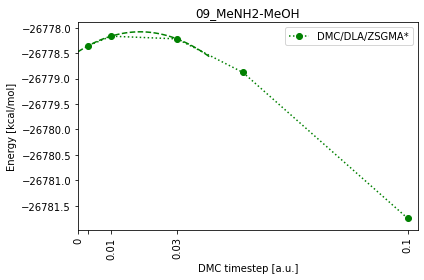

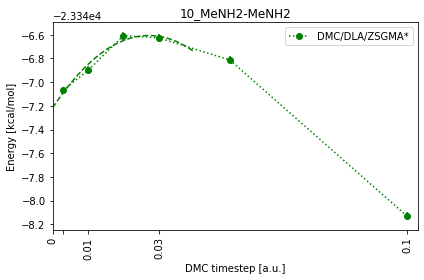

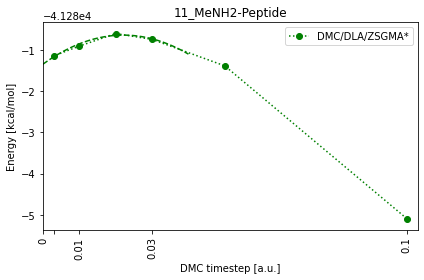

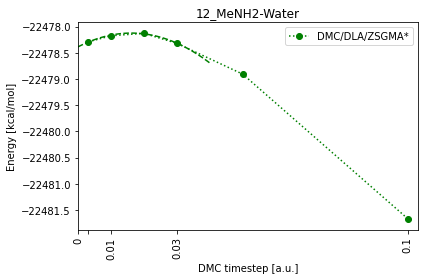

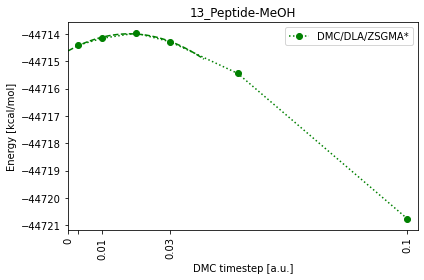

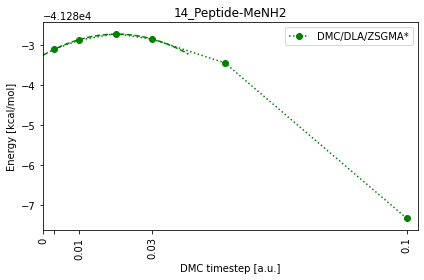

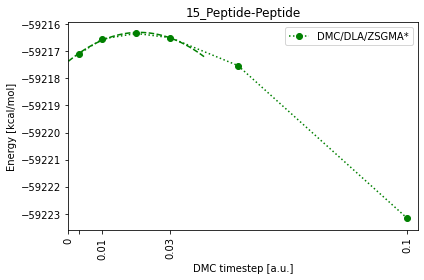

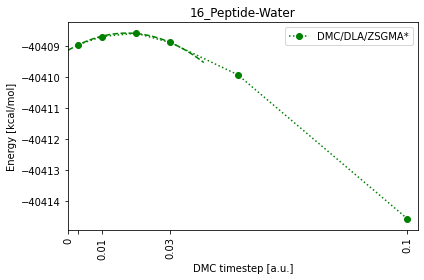

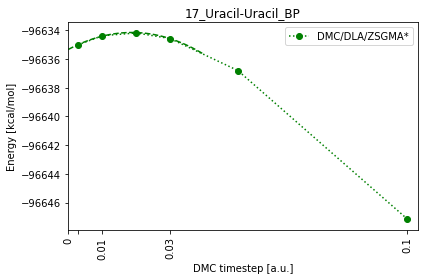

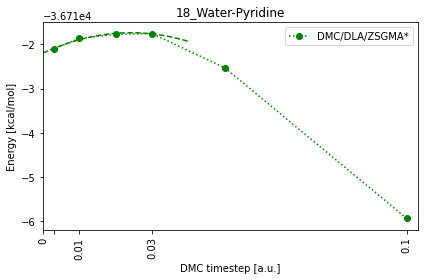

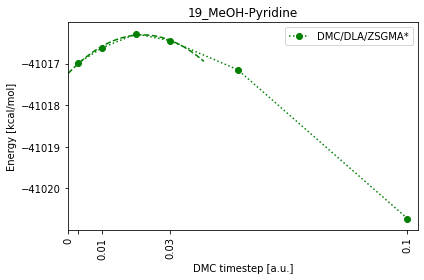

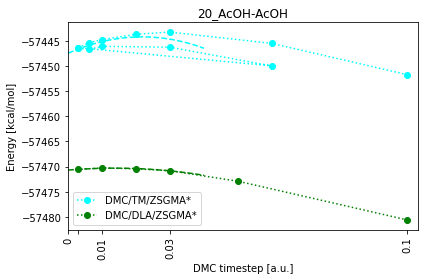

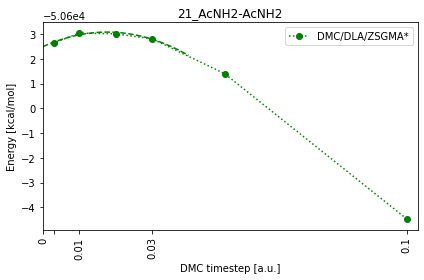

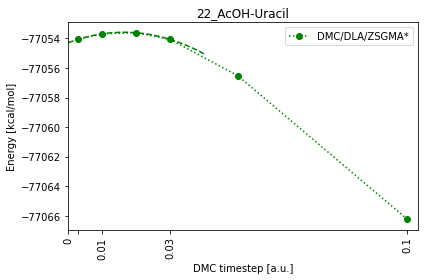

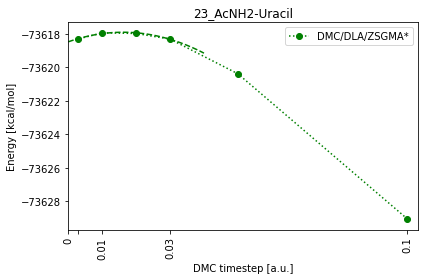

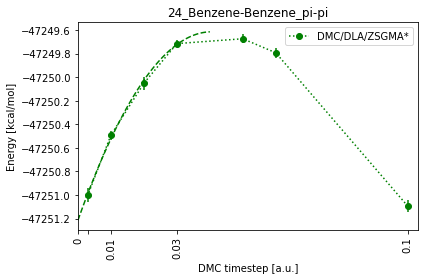

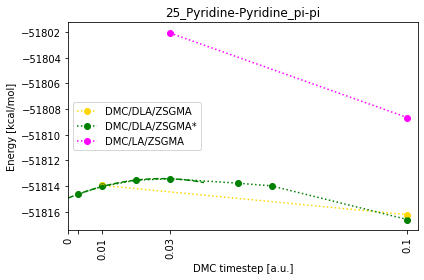

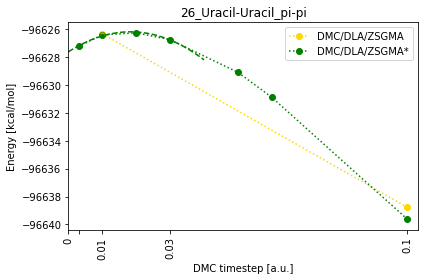

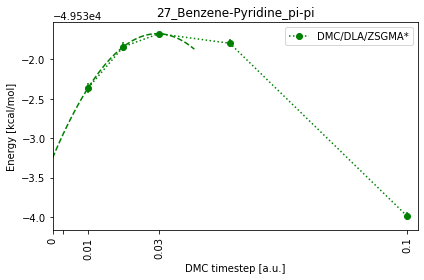

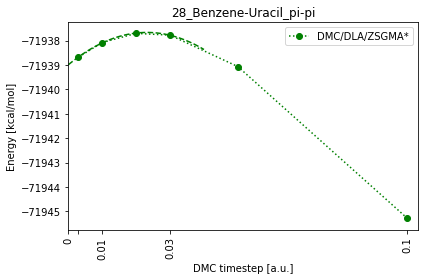

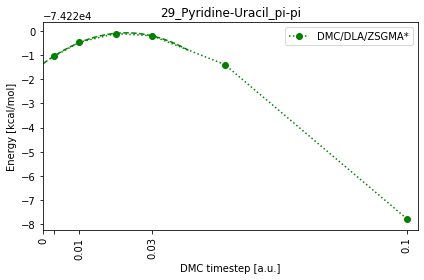

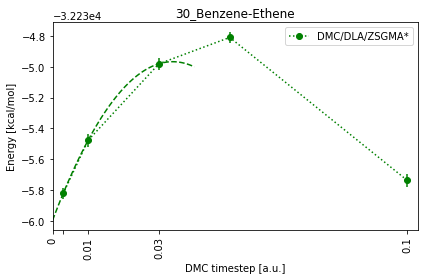

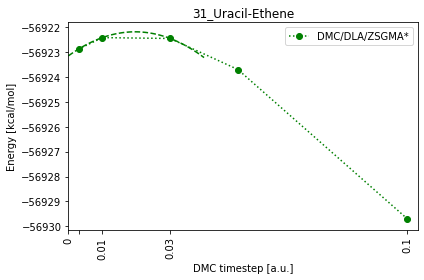

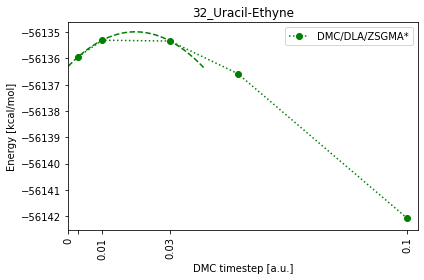

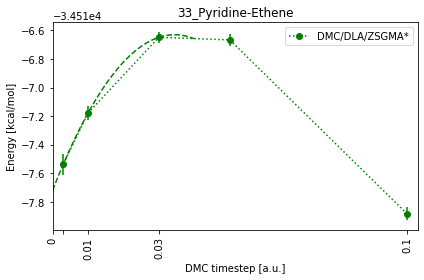

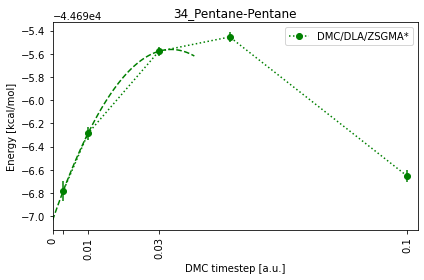

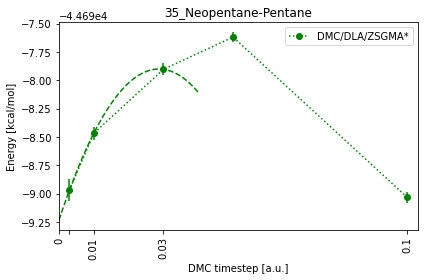

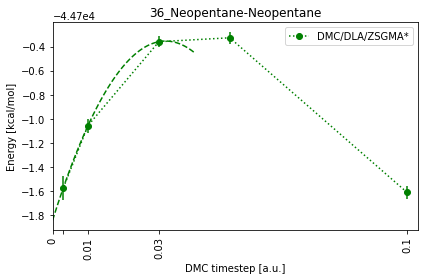

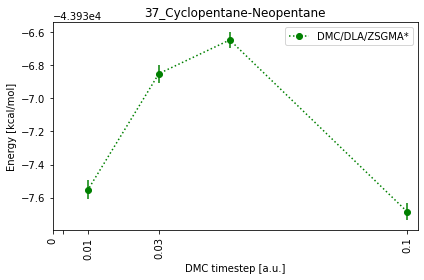

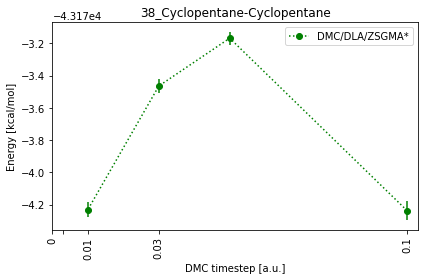

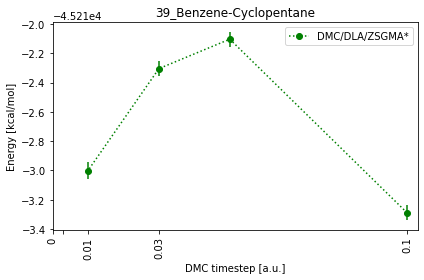

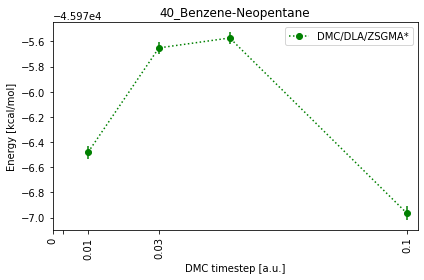

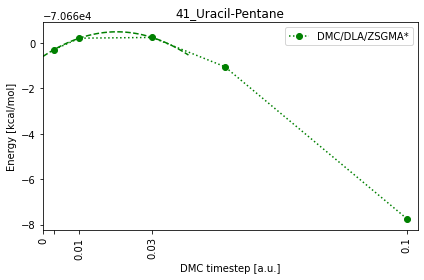

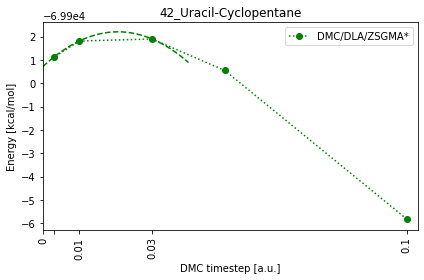

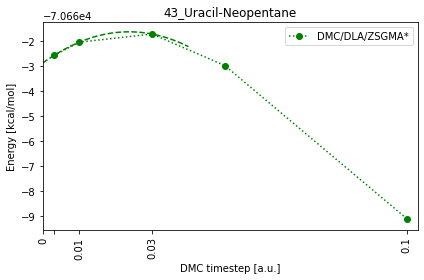

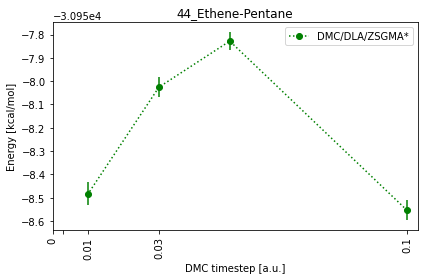

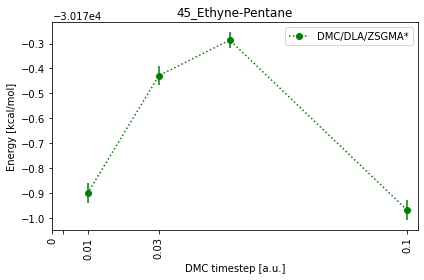

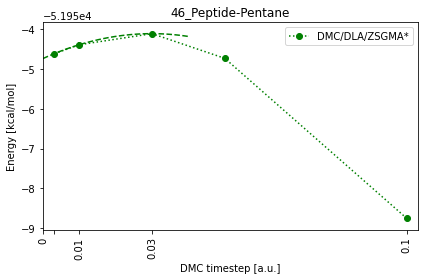

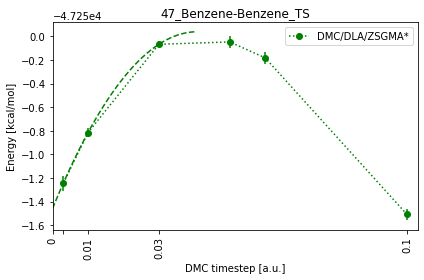

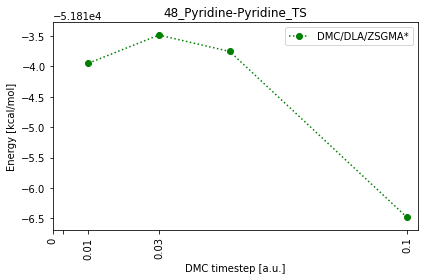

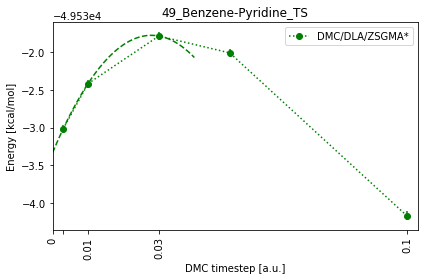

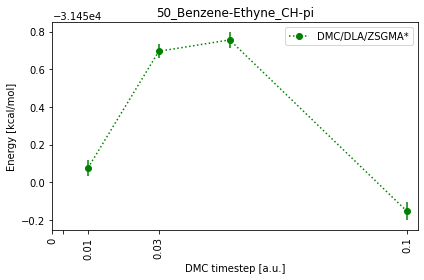

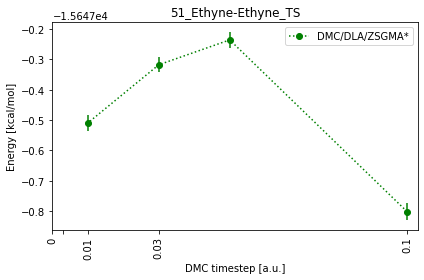

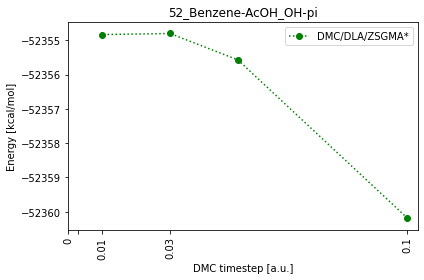

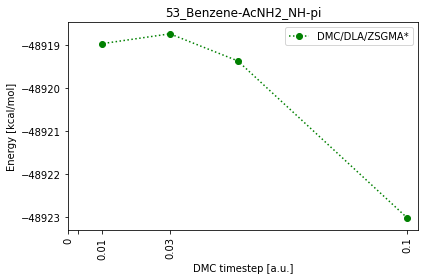

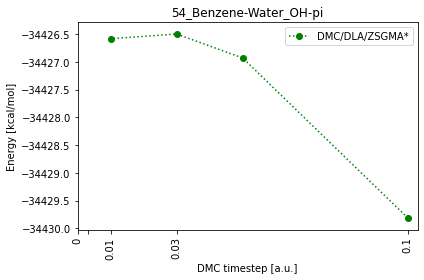

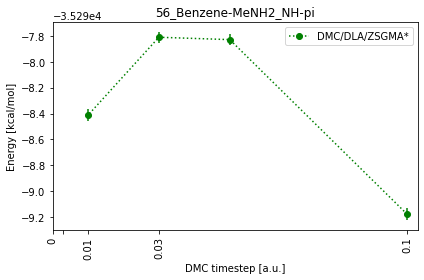

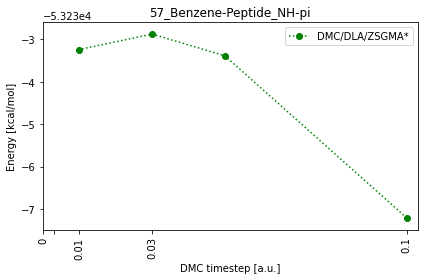

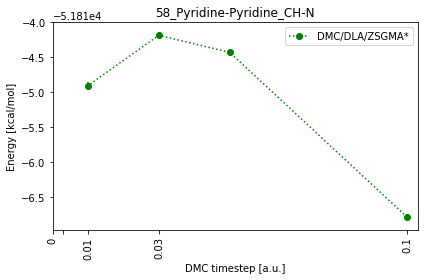

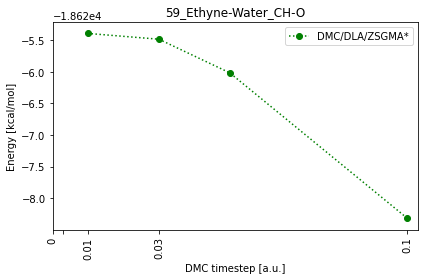

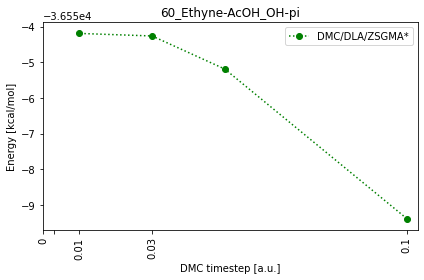

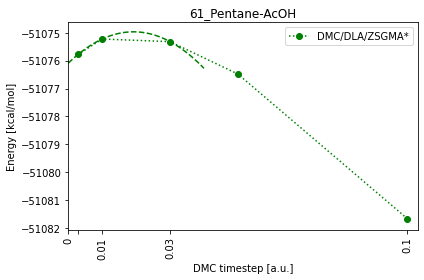

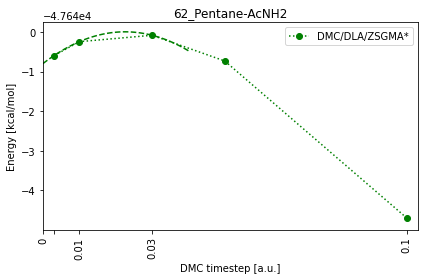

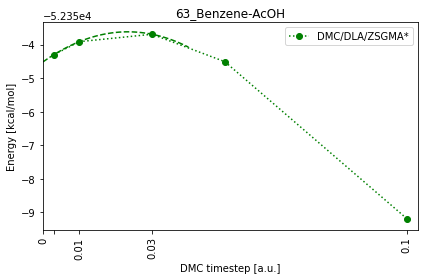

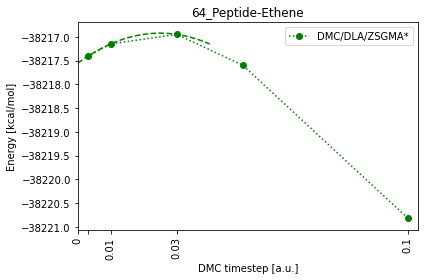

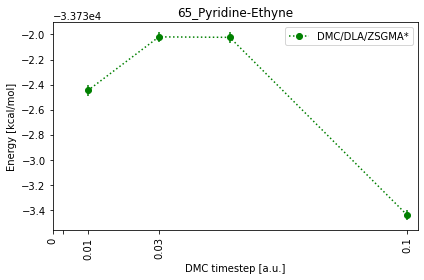

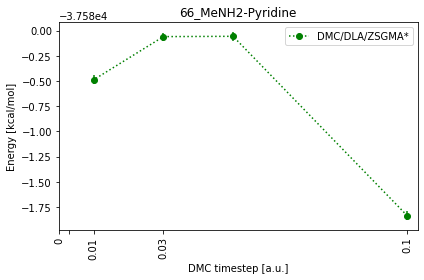

In [14]:
# Plot Total Energy for 66 dimers using dataframe Edimer

verbose = False

for i in range(1,67):
    d = Edimer[ Edimer['i']==i ]
    #print(d)
    name = d['name'].iloc[0]
    print(f'{i} {name}')
    
    fig, ax = plt.subplots() #figsize=(10, 5) )
    ax.set_title( f'{name}' )
    ax.set_xlim( [0,0.103] )
    d = d[ d['tau']<0.11 ]
    ax.set_xlabel( 'DMC timestep [a.u.]' )
    ax.set_xticks( [0, 0.003, 0.01, 0.03, 0.1 ] )
    ax.set_xticklabels( [ '0', '', '0.01', '0.03', '0.1' ], rotation=90 )
    ax.set_ylabel( 'Energy [kcal/mol]' )
    
    dmc_types = set( d['dmc_type'] )
    print(dmc_types)
    for dmc_type in dmc_types:
        print( f'{i} {dmc_type}' )

        dd = d[ d['dmc_type']==dmc_type ]
        X = dd['tau']
        Y = dd['ene']
        Yerr = dd['err']
        label = map_DMC( dmc_type )
        c = dmc_color( dmc_type )
        
        ax.errorbar( X, Y, Yerr, color=c, fmt='.' )
        ax.plot( X, Y, 'o:', label=label , color=c )

        try:
            ddfit = dd[ dd['tau']<=0.03 ]
            xdata = ddfit['tau'].to_numpy()
            ydata = ddfit['ene'].to_numpy()
            sigma = ddfit['err'].to_numpy()
            popt, pcov = curve_fit( fun_quad, xdata=xdata, ydata=ydata )
            xlinspace = np.linspace( 0, 0.04, 100 )
            funlinspace = fun_quad( xlinspace, *popt )
            ax.plot( xlinspace, funlinspace, '--', color=c )
        except:
            pass

#    ax.hlines(0,0,len(X),color='black', linestyles='dashdot')#, label='Target')
    #ax.set_yticklabels(['{:,.0f}'.format(x) for x in ax.get_yticks()])

    ax.legend() # bbox_to_anchor=(1., 1.))

    fig.tight_layout()
    fig.savefig(f'FIG03b/Etot_{i}.png',format='png')

1 01_Water-Water
1 DMCtm5 Jopt
1 DMCtm5 JoptLA
1 DMCdla5 Jopt
fit Eb = -5.159269732003218
2 02_Water-MeOH
2 DMCdla5 Jopt
fit Eb = -5.864870949449145
3 03_Water-MeNH2
3 DMCdla5 Jopt
fit Eb = -7.175862565858226
4 04_Water-Peptide
4 DMCdla5 Jopt
fit Eb = -8.553968103661722
5 05_MeOH-MeOH
5 DMCdla5 Jopt
fit Eb = -6.029984736056509
6 06_MeOH-MeNH2
6 DMCdla5 Jopt
fit Eb = -7.865620580519373
7 07_MeOH-Peptide
7 DMCdla5 Jopt
fit Eb = -8.638302509631016
8 08_MeOH-Water
8 DMCdla5 Jopt
fit Eb = -5.269572236452281
9 09_MeNH2-MeOH
9 DMCdla5 Jopt
fit Eb = -3.13439061517526


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


10 10_MeNH2-MeNH2
10 DMCdla5 Jopt
fit Eb = -4.217041353878522
11 11_MeNH2-Peptide
11 DMCdla5 Jopt
fit Eb = -5.593060355539256
12 12_MeNH2-Water
12 DMCdla5 Jopt
fit Eb = -7.551828387416365


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


13 13_Peptide-MeOH
13 DMCdla5 Jopt
fit Eb = -6.456506886031222
14 14_Peptide-MeNH2
14 DMCdla5 Jopt
fit Eb = -7.628107608274572
15 15_Peptide-Peptide
15 DMCdla5 Jopt
fit Eb = -8.876069383422443
16 16_Peptide-Water
16 DMCdla5 Jopt
fit Eb = -5.36140891610592
17 17_Uracil-Uracil_BP
17 DMCdla5 Jopt


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


fit Eb = -17.88706382002404
18 18_Water-Pyridine
18 DMCdla5 Jopt
fit Eb = -7.273587339706579
19 19_MeOH-Pyridine
19 DMCdla5 Jopt
fit Eb = -7.893883332690824
20 20_AcOH-AcOH
20 DMCdla5 Jopt
fit Eb = -20.17687306618488


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-15-424ad157daca>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots() #figsize=(10, 5) )
/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


21 21_AcNH2-AcNH2
21 DMCdla5 Jopt
fit Eb = -16.890693908063053
22 22_AcOH-Uracil
22 DMCdla5 Jopt
fit Eb = -20.611299902860313
23 23_AcNH2-Uracil
23 DMCdla5 Jopt
fit Eb = -19.84516722334807
24 24_Benzene-Benzene_pi-pi
24 DMCdla5 Jopt
fit Eb = -2.3482299033190803
25 25_Pyridine-Pyridine_pi-pi
25 DMCdla Jopt
25 DMCdla5 Jopt
fit Eb = -3.505879589353445
25 DMC Jopt
26 26_Uracil-Uracil_pi-pi
26 DMCdla5 Jopt
fit Eb = -9.224478904170006


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


27 27_Benzene-Pyridine_pi-pi
27 DMCdla5 Jopt
fit Eb = -3.066066953701389
28 28_Benzene-Uracil_pi-pi
28 DMCdla5 Jopt
fit Eb = -5.092221592639787
29 29_Pyridine-Uracil_pi-pi
29 DMCdla5 Jopt
fit Eb = -6.408751052619443
30 30_Benzene-Ethene
30 DMCdla5 Jopt
fit Eb = -1.1509464809052161
31 31_Uracil-Ethene
31 DMCdla5 Jopt
fit Eb = -3.1758452049657317
32 32_Uracil-Ethyne
32 DMCdla5 Jopt
fit Eb = -3.4721448510477524
33 33_Pyridine-Ethene


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


33 DMCdla5 Jopt
fit Eb = -1.6305930228525656
34 34_Pentane-Pentane
34 DMCdla5 Jopt
fit Eb = -3.6140014492249284
35 35_Neopentane-Pentane
35 DMCdla5 Jopt
fit Eb = -2.492586042831577
36 36_Neopentane-Neopentane
36 DMCdla5 Jopt
fit Eb = -1.7193503786304956
37 37_Cyclopentane-Neopentane
37 DMCdla5 Jopt
fit Eb = -2.2118224053290803
38 38_Cyclopentane-Cyclopentane
38 DMCdla5 Jopt
fit Eb = -3.0604533444297677
39 39_Benzene-Cyclopentane
39 DMCdla5 Jopt
fit Eb = -3.351097558625735
40 40_Benzene-Neopentane


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


40 DMCdla5 Jopt
fit Eb = -2.8070811329449588
41 41_Uracil-Pentane
41 DMCdla5 Jopt
fit Eb = -4.434605148753616
42 42_Uracil-Cyclopentane
42 DMCdla5 Jopt
fit Eb = -3.584208066749159
43 43_Uracil-Neopentane
43 DMCdla5 Jopt
fit Eb = -3.5070713047757005


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


44 44_Ethene-Pentane
44 DMCdla5 Jopt
fit Eb = -1.9226706996819074
45 45_Ethyne-Pentane
45 DMCdla5 Jopt
fit Eb = -1.6470470947641045
46 46_Peptide-Pentane
46 DMCdla5 Jopt
fit Eb = -4.051269995678533
47 47_Benzene-Benzene_TS
47 DMCdla5 Jopt
fit Eb = -2.615174849910337
48 48_Pyridine-Pyridine_TS


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


48 DMCdla5 Jopt
fit Eb = -3.403646193332224
49 49_Benzene-Pyridine_TS
49 DMCdla5 Jopt
fit Eb = -3.1165709154830754
50 50_Benzene-Ethyne_CH-pi
50 DMCdla5 Jopt
fit Eb = -2.9619203107041403
51 51_Ethyne-Ethyne_TS
51 DMCdla5 Jopt
fit Eb = -1.5537732324919997
52 52_Benzene-AcOH_OH-pi
52 DMCdla5 Jopt
fit Eb = -4.539635865024733
53 53_Benzene-AcNH2_NH-pi
53 DMCdla5 Jopt
fit Eb = -4.254081685156559
54 54_Benzene-Water_OH-pi
54 DMCdla5 Jopt
fit Eb = -3.239123114991509
55 55_Benzene-MeOH_OH-pi
55 DMCdla5 Jopt
fit Eb = -4.019726694668804
56 56_Benzene-MeNH2_NH-pi
56 DMCdla5 Jopt
fit Eb = -3.126742577809782
57 57_Benzene-Peptide_NH-pi
57 DMCdla5 Jopt
fit Eb = -5.186033325805529
58 58_Pyridine-Pyridine_CH-N
58 DMCdla5 Jopt
fit Eb = -4.467448216845629
59 59_Ethyne-Water_CH-O
59 DMCdla5 Jopt
fit Eb = -3.082526791251705
60 60_Ethyne-AcOH_OH-pi
60 DMCdla5 Jopt
fit Eb = -5.052103523254725
61 61_Pentane-AcOH
61 DMCdla5 Jopt
fit Eb = -2.669212789698468


/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


62 62_Pentane-AcNH2
62 DMCdla5 Jopt
fit Eb = -3.2027245893511695
63 63_Benzene-AcOH
63 DMCdla5 Jopt
fit Eb = -3.6905805466205313
64 64_Peptide-Ethene
64 DMCdla5 Jopt
fit Eb = -2.9568423044508694
65 65_Pyridine-Ethyne
65 DMCdla5 Jopt
fit Eb = -4.29500184856057
66 66_MeNH2-Pyridine
66 DMCdla5 Jopt

/Users/zen/.pyenv/versions/3.8.7/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',



fit Eb = -4.003775664292342


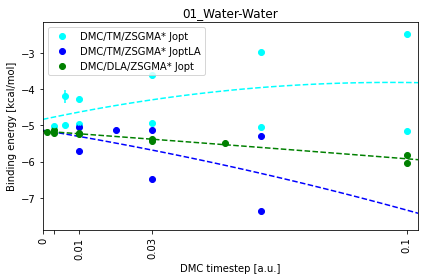

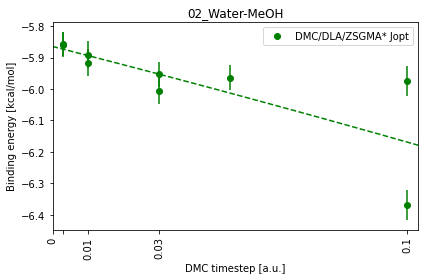

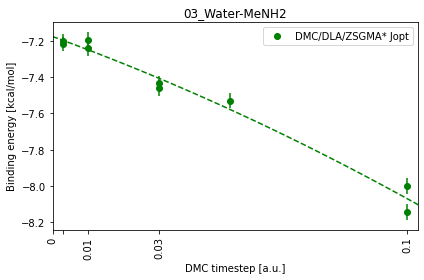

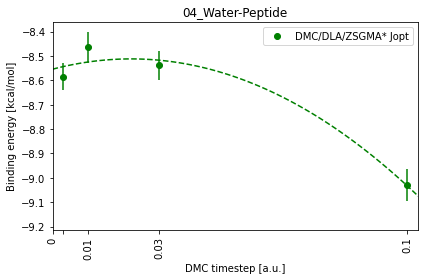

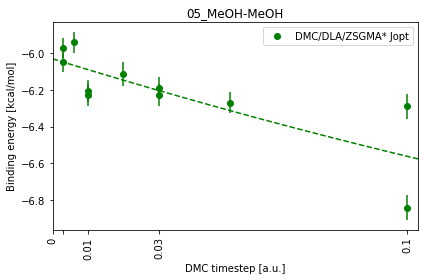

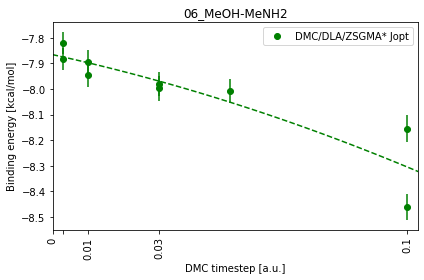

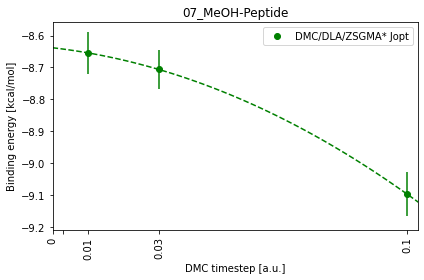

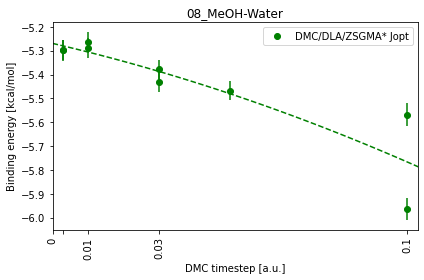

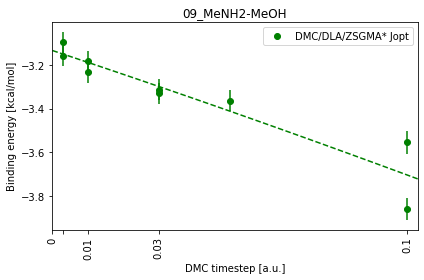

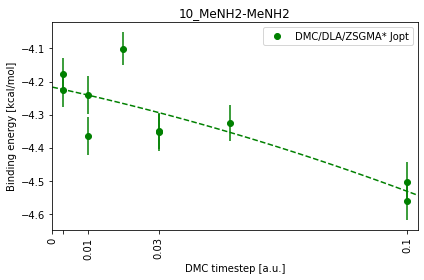

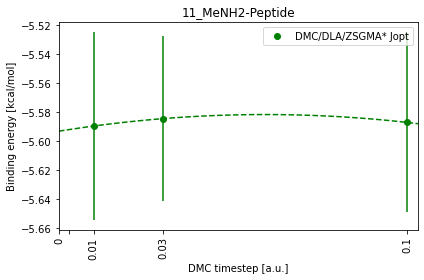

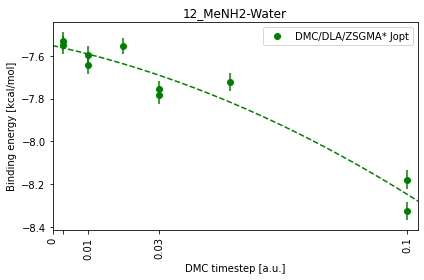

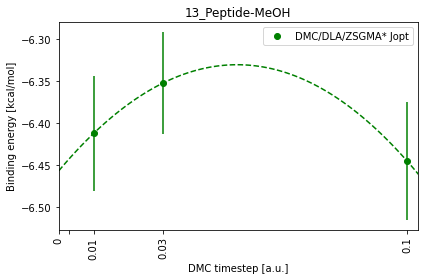

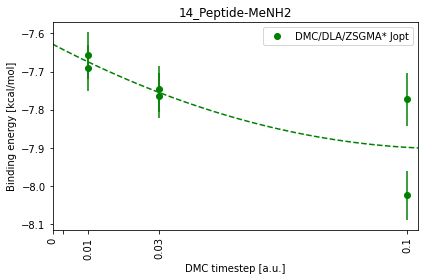

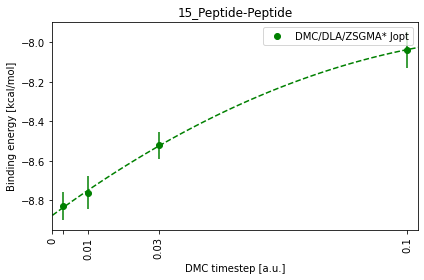

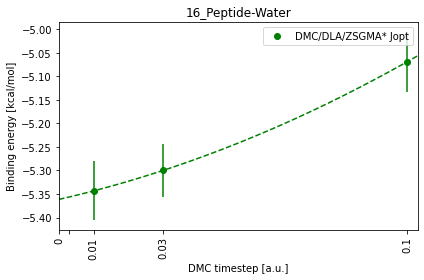

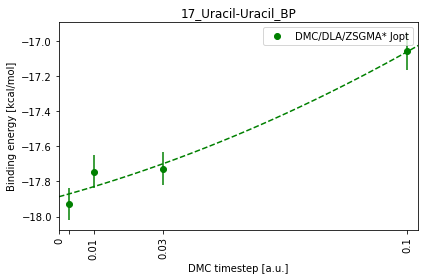

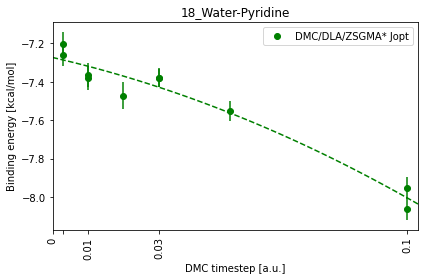

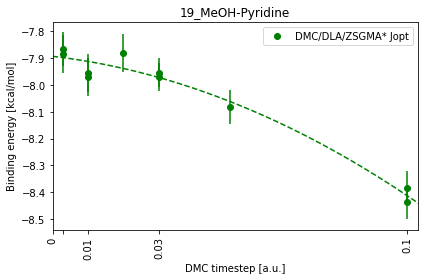

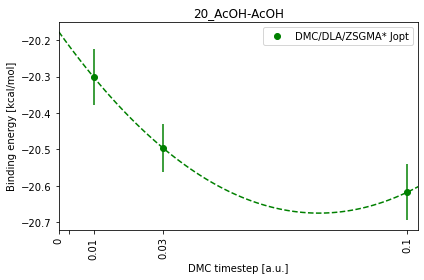

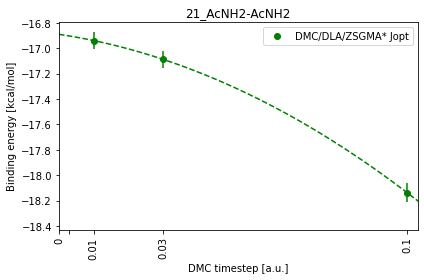

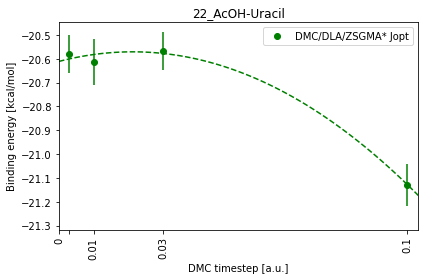

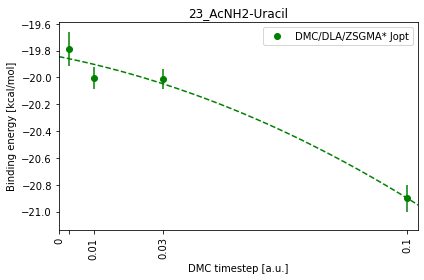

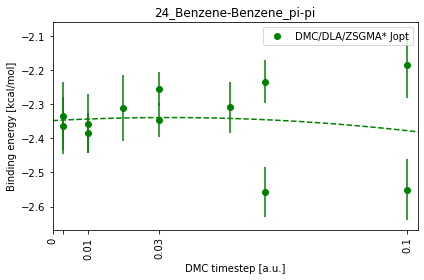

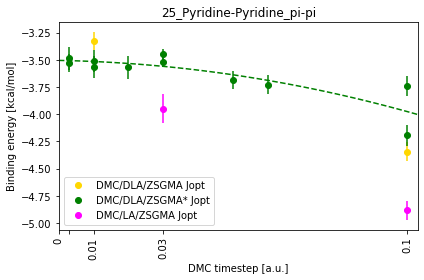

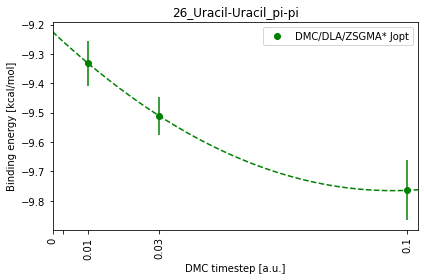

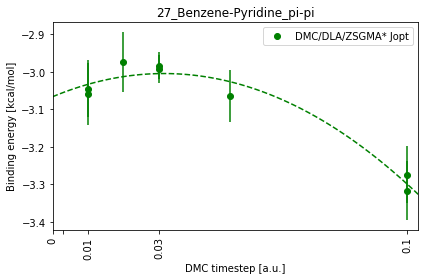

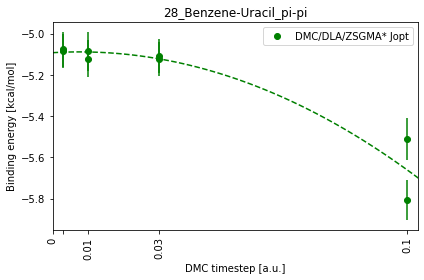

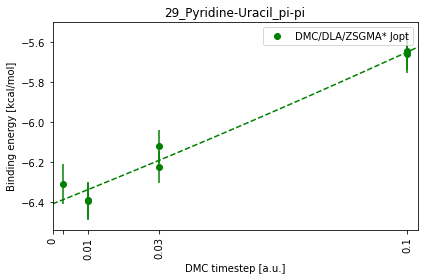

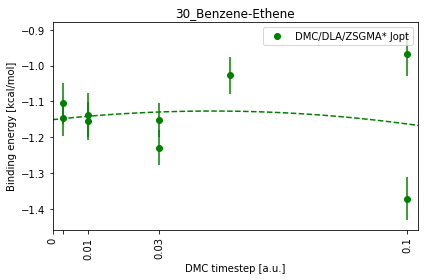

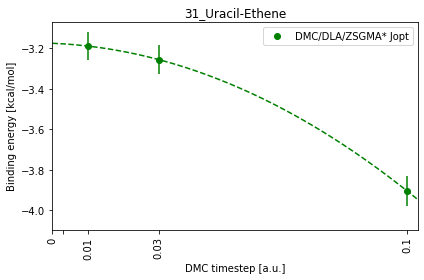

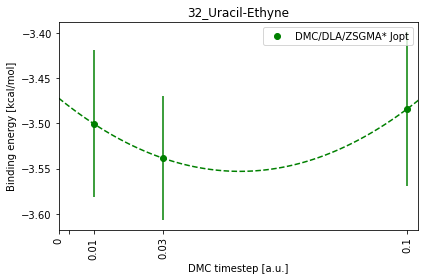

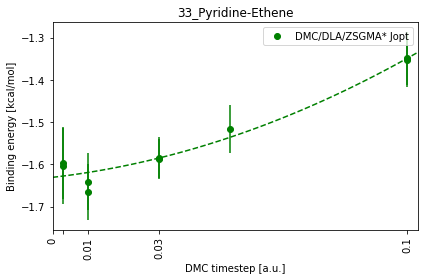

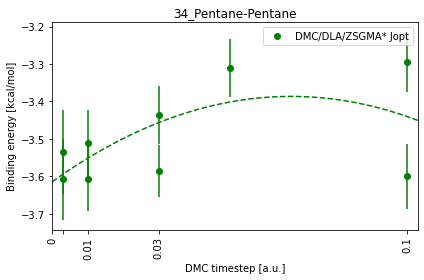

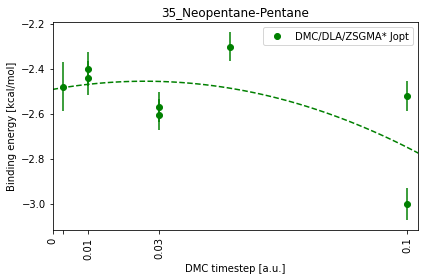

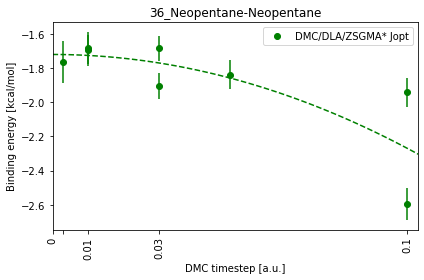

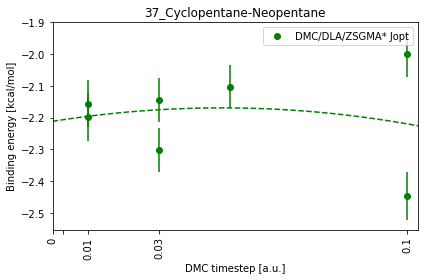

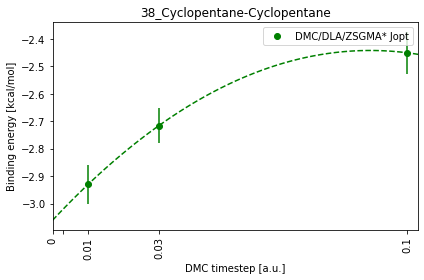

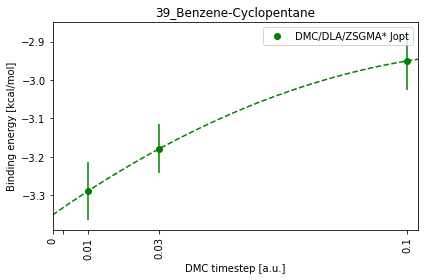

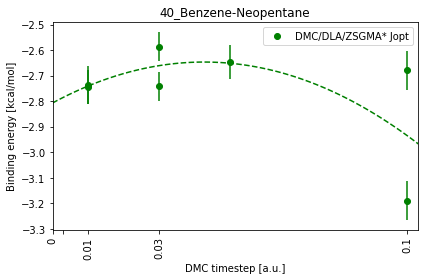

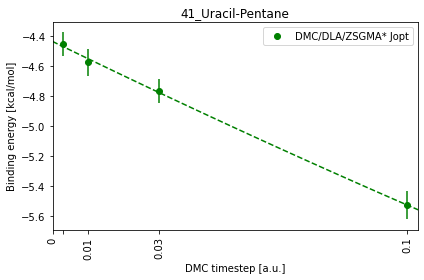

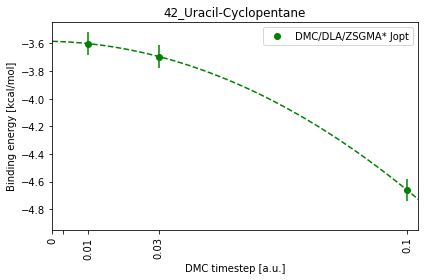

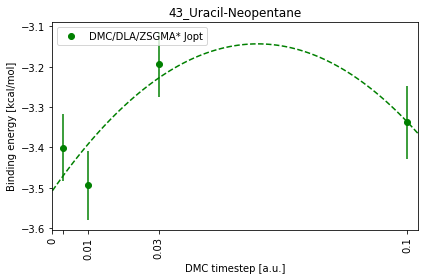

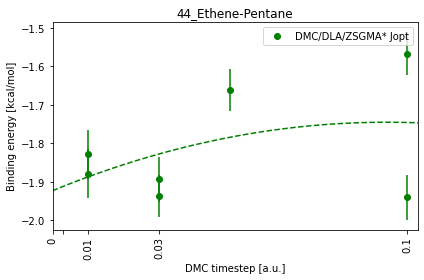

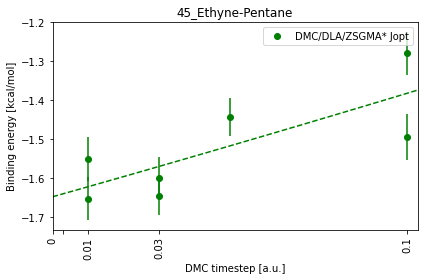

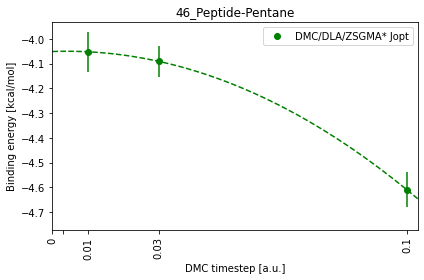

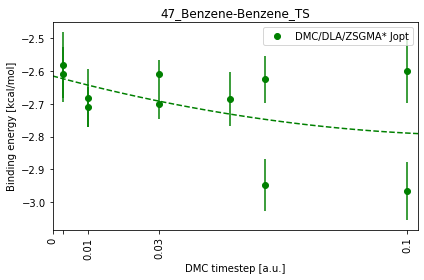

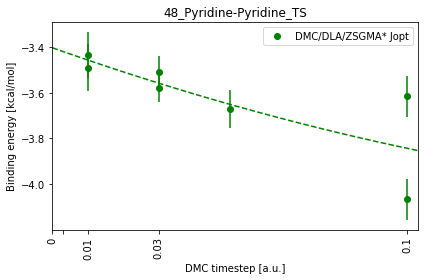

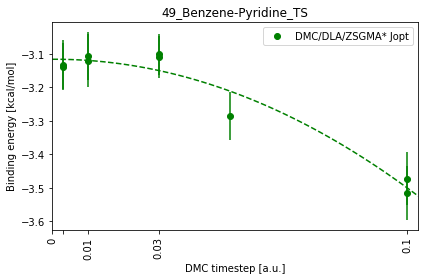

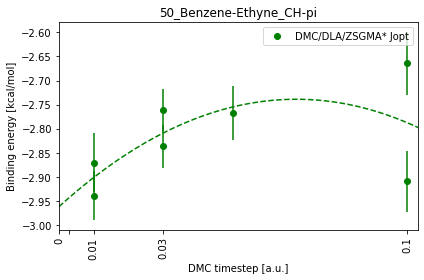

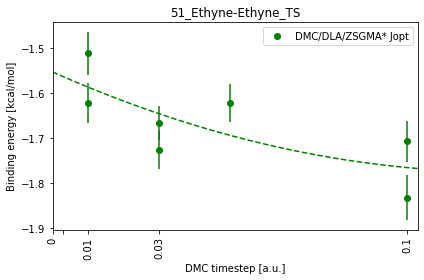

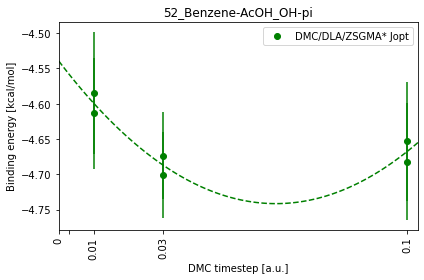

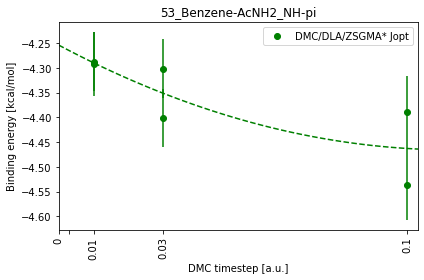

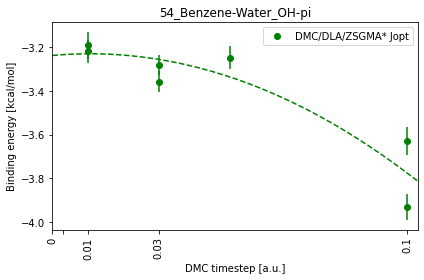

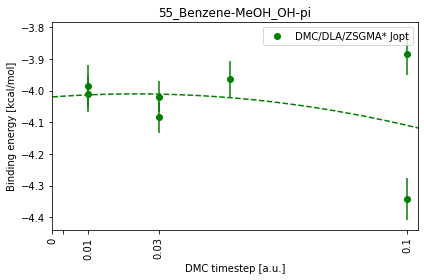

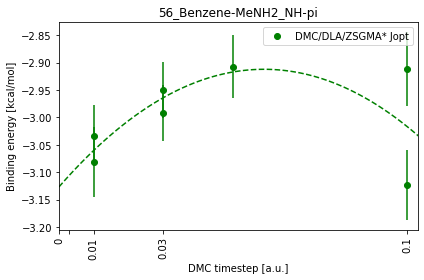

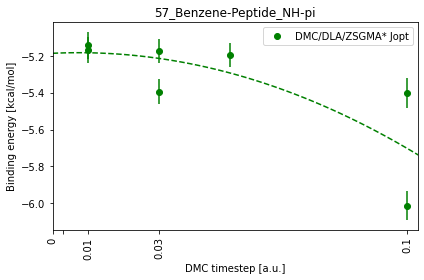

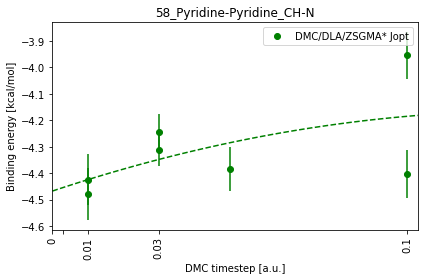

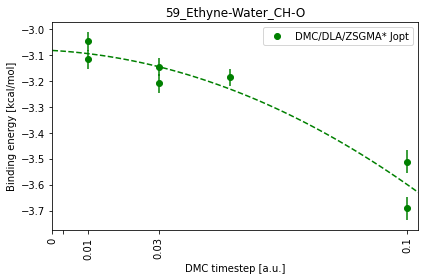

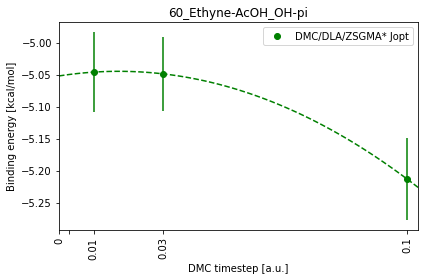

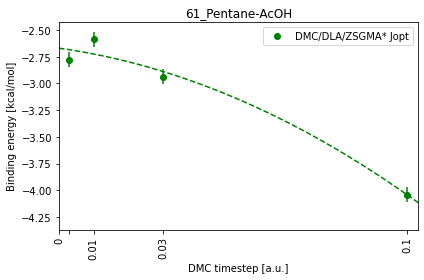

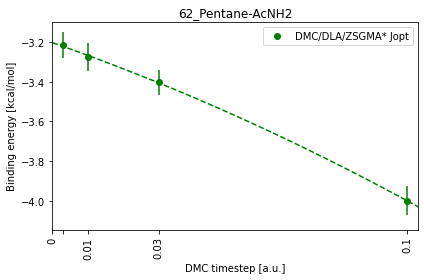

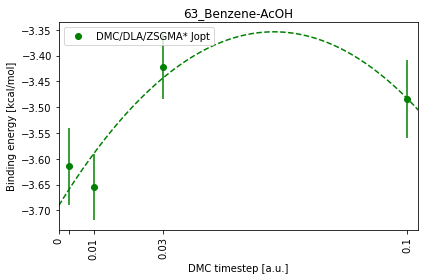

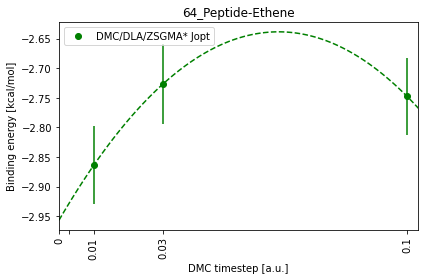

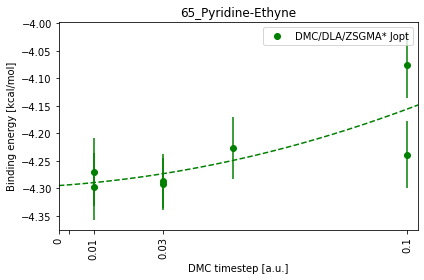

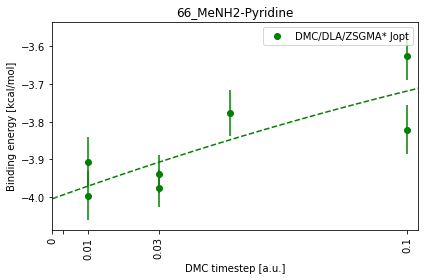

In [15]:
# Plot Binding Energy for 66 dimers using dataframe Eb
verbose = False

ref = {}
for i in range(1,67):
    d = Eb[ Eb['i']==i ]
    #print(d)
    name = d['name'].iloc[0]
    print(f'{i} {name}')
    
    fig, ax = plt.subplots() #figsize=(10, 5) )
    ax.set_title( f'{name}' )
    ax.set_xlim( [0,0.103] )
    d = d[ d['tau']<0.11 ]
    ax.set_xlabel( 'DMC timestep [a.u.]' )
    ax.set_xticks( [0, 0.003, 0.01, 0.03, 0.1 ] )
    ax.set_xticklabels( [ '0', '', '0.01', '0.03', '0.1' ], rotation=90 )
    ax.set_ylabel( 'Binding energy [kcal/mol]' )
    
    dmc_types = set( d['dmc_type'] )
    for dmc_type in dmc_types:
        dd = d[ d['dmc_type']==dmc_type ]
        Jas_set = set( dd['Jas'] )
        for Jas in Jas_set:
            print( f'{i} {dmc_type} {Jas}' )

            ddd = dd[ dd['Jas']==Jas ]
            X = ddd['tau']
            Y = ddd['ene']
            Yerr = ddd['err']
            label = f'{map_DMC(dmc_type)} {Jas}'
            c = dmc_color( dmc_type, Jas )

            ax.errorbar( X, Y, Yerr, color=c, fmt='.' )
            ax.plot( X, Y, 'o', label=label , color=c )
            
            try:
                ddfit = ddd[ ddd['tau']<=0.10 ]
                xdata = ddfit['tau'].to_numpy()
                ydata = ddfit['ene'].to_numpy()
                sigma = ddfit['err'].to_numpy()
                popt, pcov = curve_fit( fun_quad, xdata=xdata, ydata=ydata )
                xlinspace = np.linspace( 0, 0.11, 100 )
                funlinspace = fun_quad( xlinspace, *popt )
                ax.plot( xlinspace, funlinspace, '--', color=c )
                if (dmc_type=='DMCdla5' and Jas=='Jopt'):
                    print(f'fit Eb = {popt[0]}')
                    ref[i] = popt[0]
            except:
                pass


#    ax.hlines(0,0,len(X),color='black', linestyles='dashdot')#, label='Target')
    #ax.set_yticklabels(['{:,.0f}'.format(x) for x in ax.get_yticks()])

    ax.legend() # bbox_to_anchor=(1., 1.))

    fig.tight_layout()
    fig.savefig(f'FIG03b/Eb_{i}.png',format='png')

s = pd.Series( ref )
df_refs['DMC'] = s.values

1 01_Water-Water
1 DMCtm5 Jopt
1 DMCtm5 JoptLA
1 DMCdla5 Jopt
fit Eb = -5.158204428306479
2 02_Water-MeOH
2 DMCdla5 Jopt
fit Eb = -5.872925602223193
3 03_Water-MeNH2
3 DMCdla5 Jopt
fit Eb = -7.181420536492394
4 04_Water-Peptide
4 DMCdla5 Jopt
fit Eb = -8.561107618873187
5 05_MeOH-MeOH
5 DMCdla5 Jopt
fit Eb = -6.035417975055244
6 06_MeOH-MeNH2
6 DMCdla5 Jopt
fit Eb = -7.869106940011686
7 07_MeOH-Peptide
7 DMCdla5 Jopt
fit Eb = -8.603451293760243
8 08_MeOH-Water
8 DMCdla5 Jopt
fit Eb = -5.270650673849203
9 09_MeNH2-MeOH
9 DMCdla5 Jopt
fit Eb = -3.1399003219477644
10 10_MeNH2-MeNH2
10 DMCdla5 Jopt
fit Eb = -4.2163717712281095
11 11_MeNH2-Peptide
11 DMCdla5 Jopt
fit Eb = -5.453191200468683
12 12_MeNH2-Water
12 DMCdla5 Jopt
fit Eb = -7.549121498085911
13 13_Peptide-MeOH
13 DMCdla5 Jopt
fit Eb = -6.380092997901899
14 14_Peptide-MeNH2
14 DMCdla5 Jopt
fit Eb = -7.556555586713102
15 15_Peptide-Peptide
15 DMCdla5 Jopt
fit Eb = -8.917211069654098
16 16_Peptide-Water
16 DMCdla5 Jopt
fit Eb = -5.36

<ipython-input-16-412afd572a3f>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots() #figsize=(10, 5) )


23 DMCdla5 Jopt
fit Eb = -19.75618100429362
24 24_Benzene-Benzene_pi-pi
24 DMCdla5 Jopt
fit Eb = -2.3497437569144894
25 25_Pyridine-Pyridine_pi-pi
25 DMCdla Jopt
25 DMCdla5 Jopt
fit Eb = -3.5134331703703396
25 DMC Jopt
26 26_Uracil-Uracil_pi-pi
26 DMCdla Jopt
26 DMCdla5 Jopt
fit Eb = -9.338984811562622
27 27_Benzene-Pyridine_pi-pi
27 DMCdla5 Jopt
fit Eb = -3.0643394541219187
28 28_Benzene-Uracil_pi-pi
28 DMCdla5 Jopt
fit Eb = -5.15475374829264
29 29_Pyridine-Uracil_pi-pi
29 DMCdla5 Jopt
fit Eb = -6.426203747003266
30 30_Benzene-Ethene
30 DMCdla5 Jopt
fit Eb = -1.1438830086643108
31 31_Uracil-Ethene
31 DMCdla5 Jopt
fit Eb = -3.2869696454147173
32 32_Uracil-Ethyne
32 DMCdla5 Jopt
fit Eb = -3.6025067815014706
33 33_Pyridine-Ethene
33 DMCdla5 Jopt
fit Eb = -1.6471623254850132
34 34_Pentane-Pentane
34 DMCdla5 Jopt
fit Eb = -3.6195428575246793
35 35_Neopentane-Pentane
35 DMCdla5 Jopt
fit Eb = -2.492586042831577
36 36_Neopentane-Neopentane
36 DMCdla5 Jopt
fit Eb = -1.7193503786304956
37 37_Cy

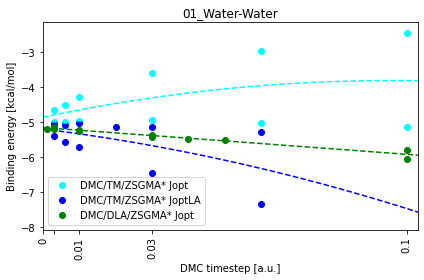

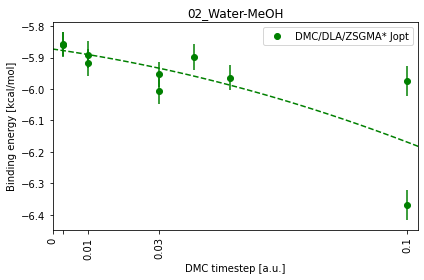

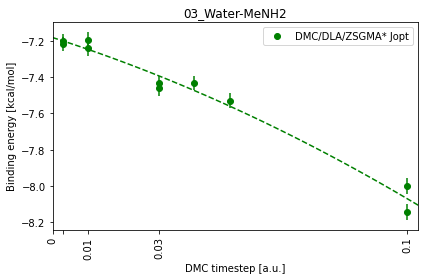

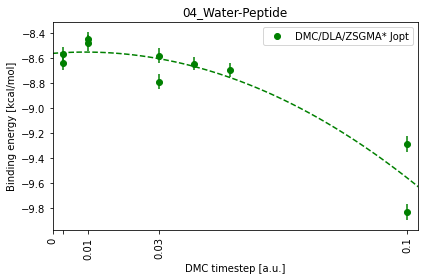

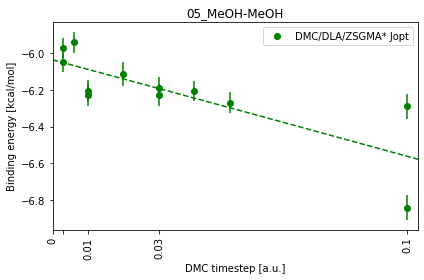

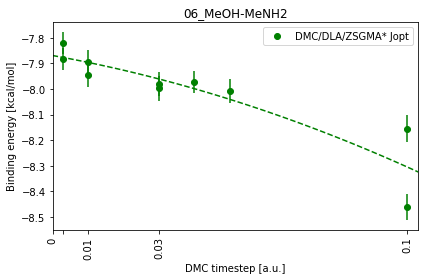

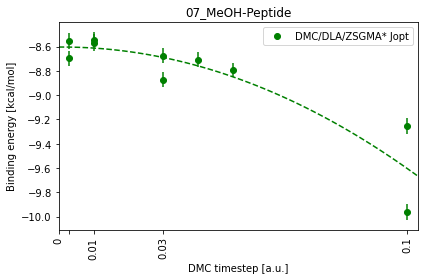

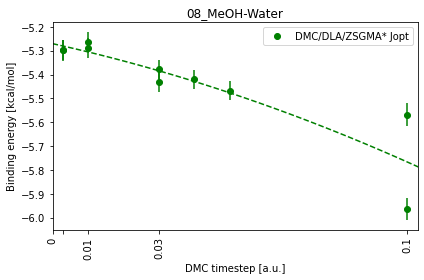

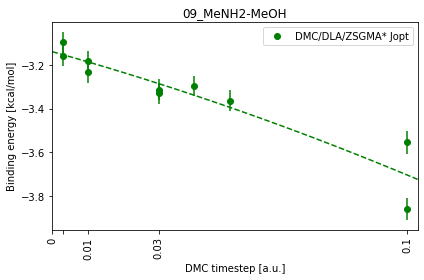

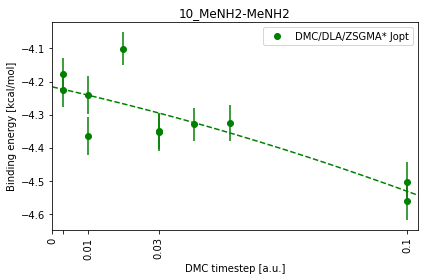

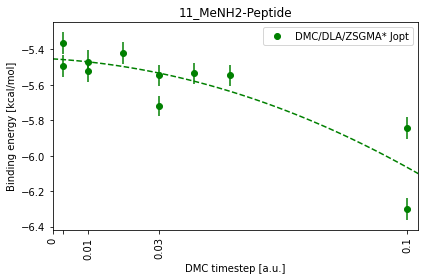

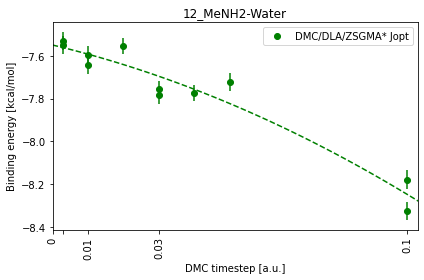

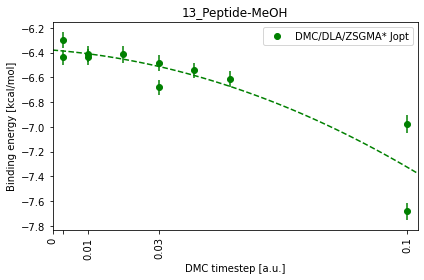

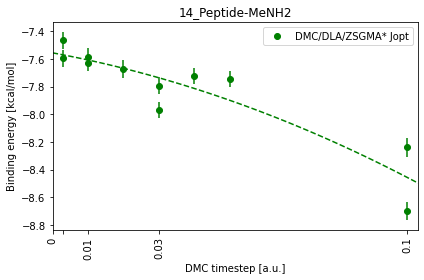

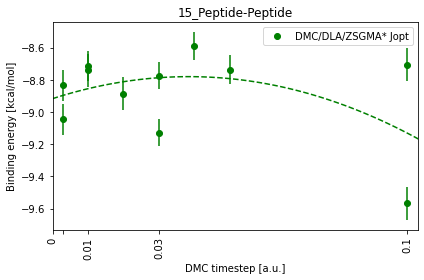

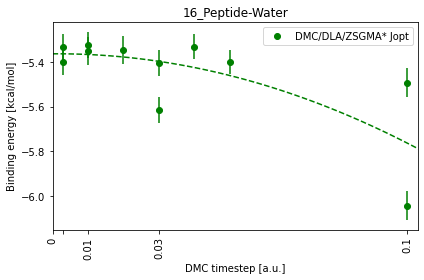

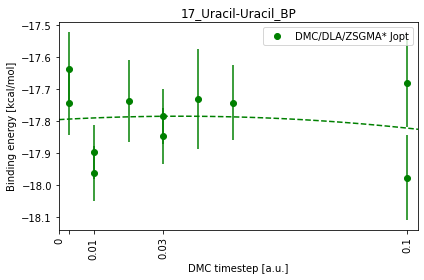

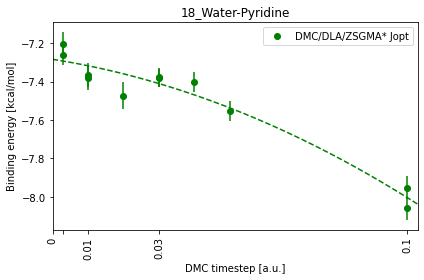

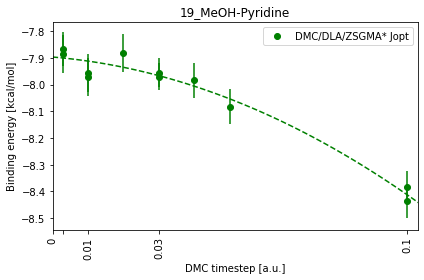

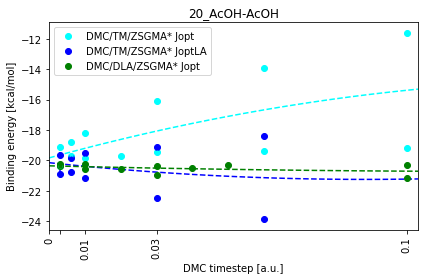

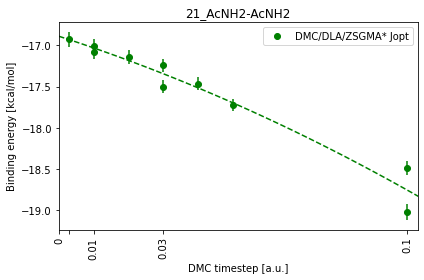

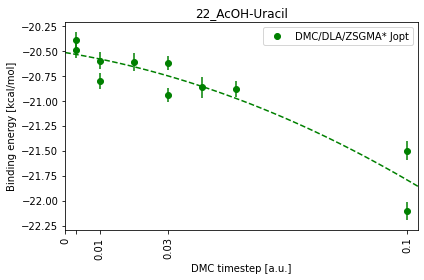

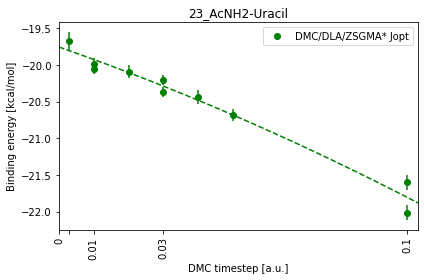

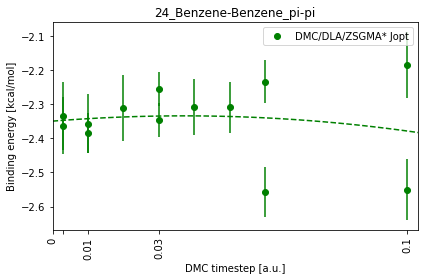

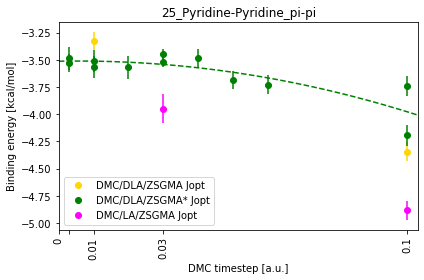

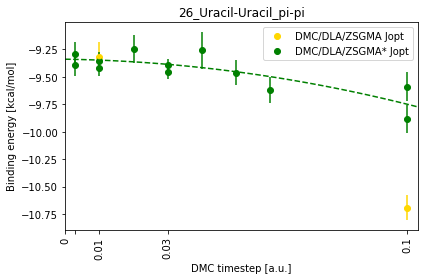

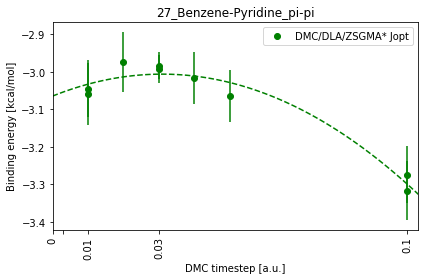

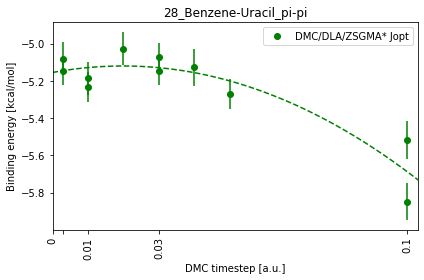

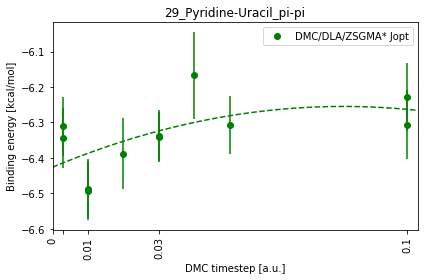

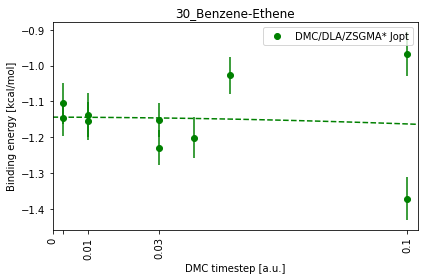

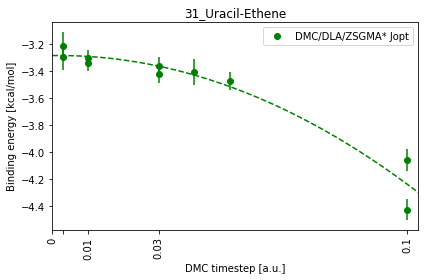

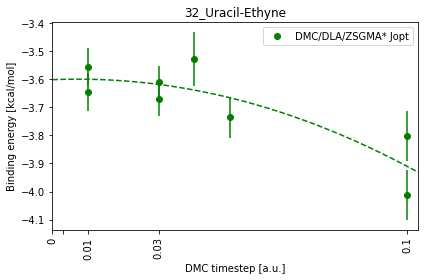

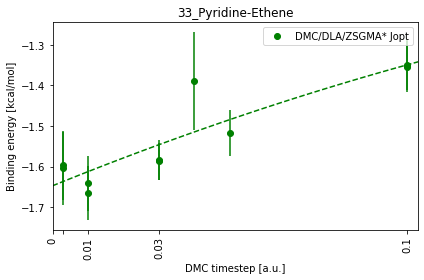

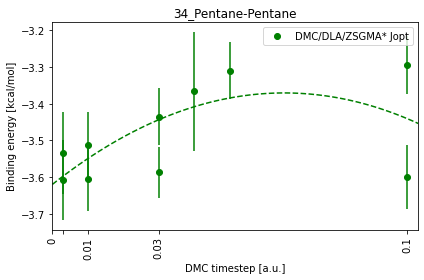

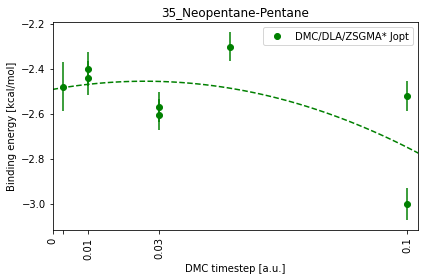

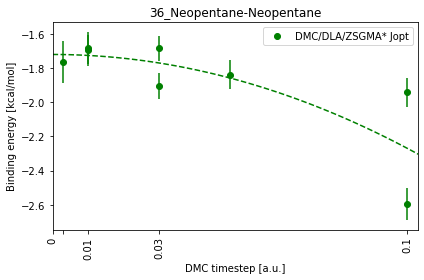

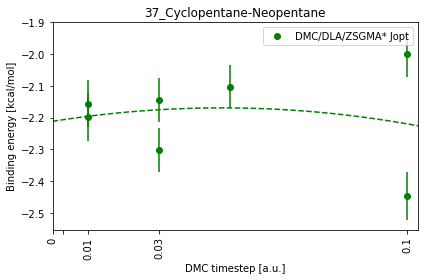

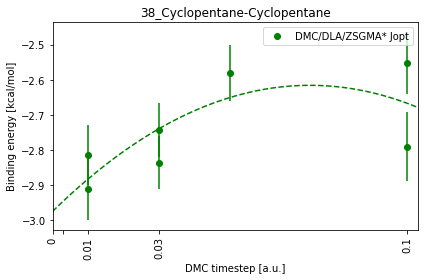

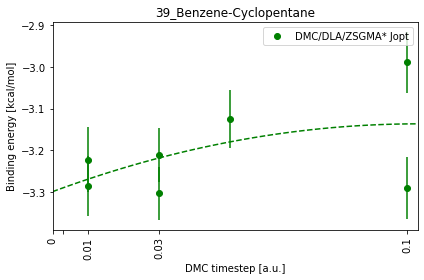

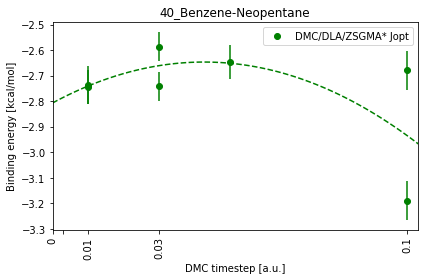

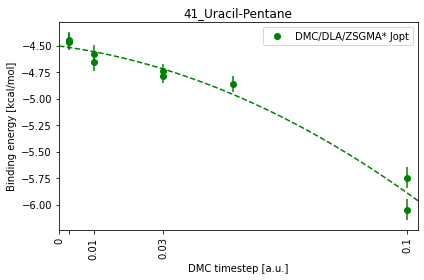

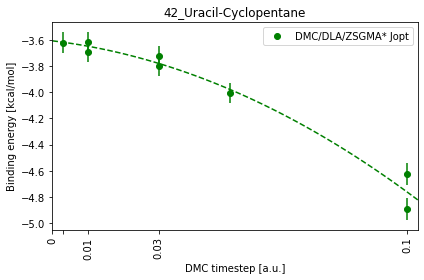

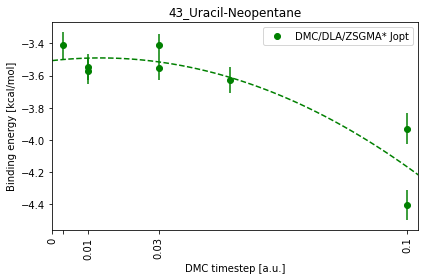

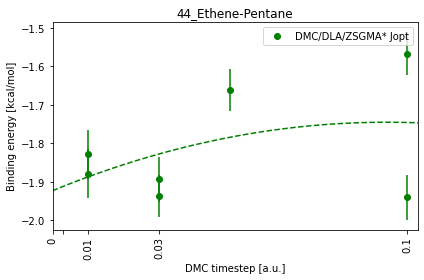

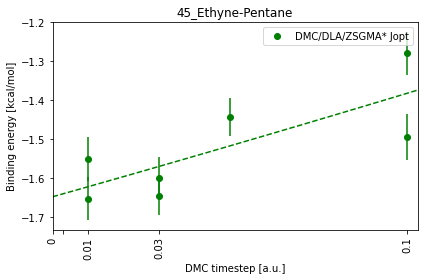

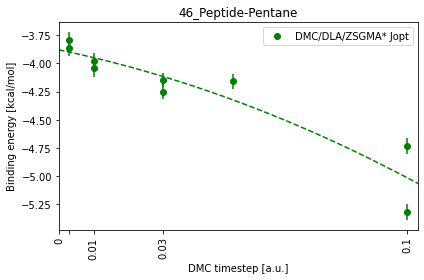

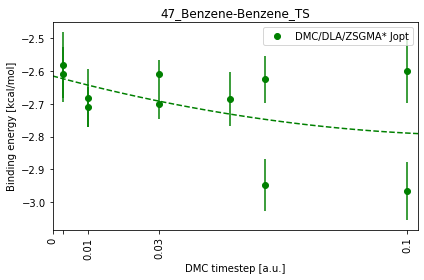

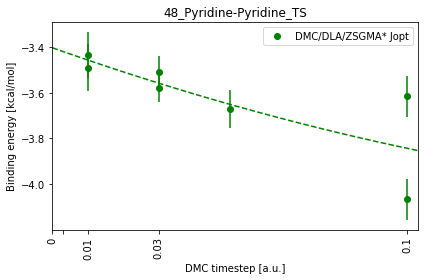

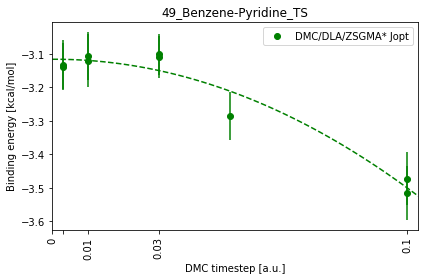

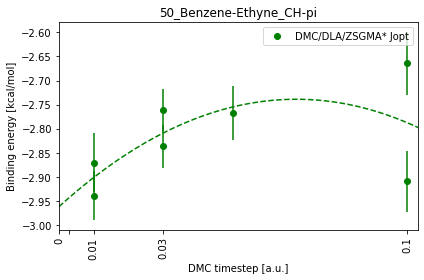

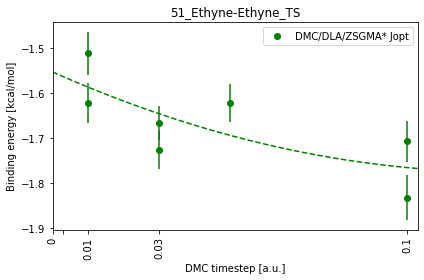

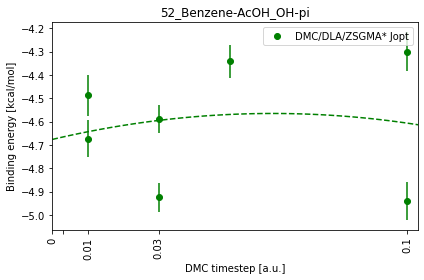

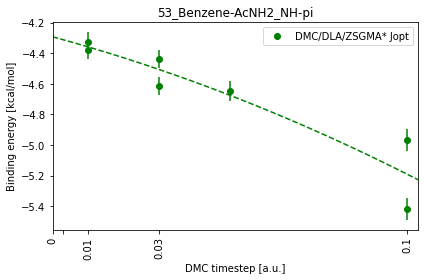

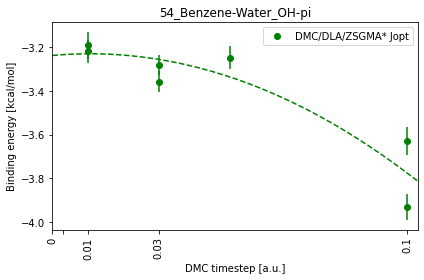

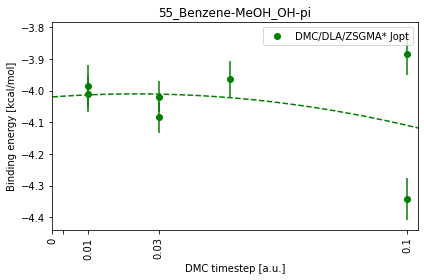

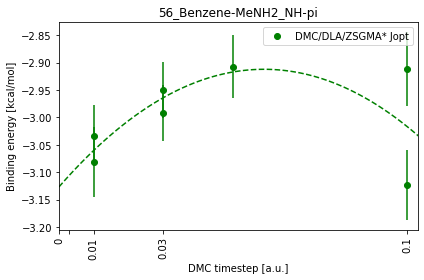

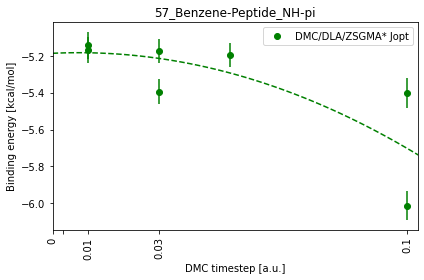

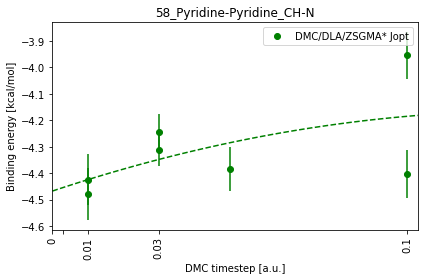

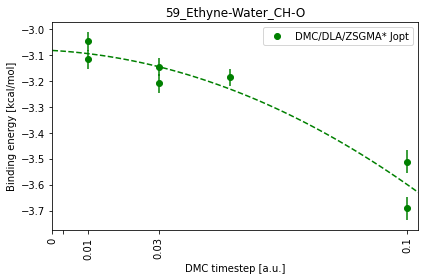

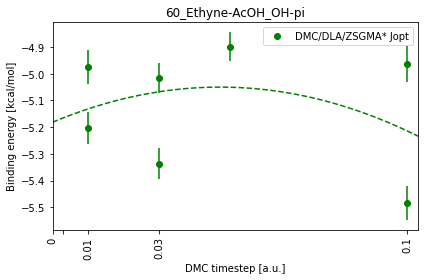

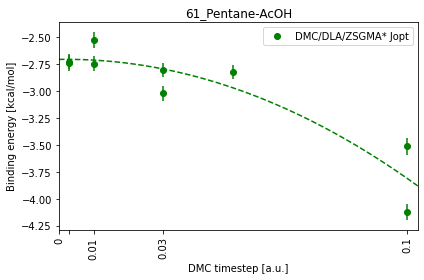

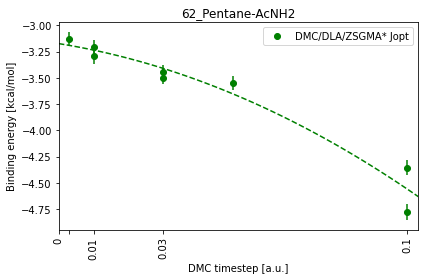

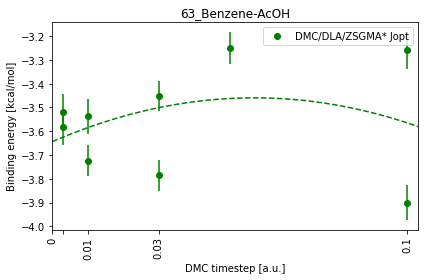

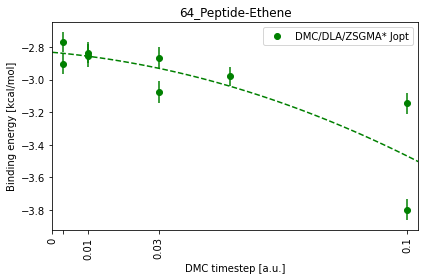

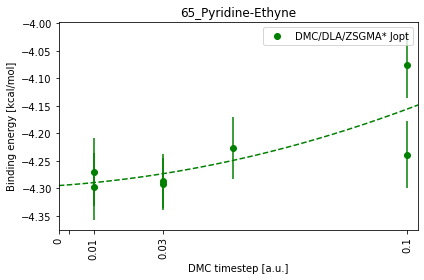

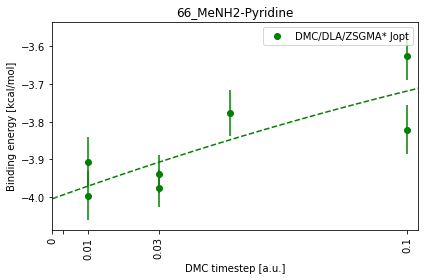

In [16]:
# Plot Binding Energy for 66 dimers using dataframe Eb_1ref
verbose = False

for i in range(1,67):
    d = Eb_1ref[ Eb_1ref['i']==i ]
    #print(d)
    name = d['name'].iloc[0]
    print(f'{i} {name}')
    
    fig, ax = plt.subplots() #figsize=(10, 5) )
    ax.set_title( f'{name}' )
    ax.set_xlim( [0,0.103] )
    d = d[ d['tau']<0.11 ]
    ax.set_xlabel( 'DMC timestep [a.u.]' )
    ax.set_xticks( [0, 0.003, 0.01, 0.03, 0.1 ] )
    ax.set_xticklabels( [ '0', '', '0.01', '0.03', '0.1' ], rotation=90 )
    ax.set_ylabel( 'Binding energy [kcal/mol]' )
    
    dmc_types = set( d['dmc_type'] )
    for dmc_type in dmc_types:
        dd = d[ d['dmc_type']==dmc_type ]
        Jas_set = set( dd['Jas'] )
        for Jas in Jas_set:
            print( f'{i} {dmc_type} {Jas}' )

            ddd = dd[ dd['Jas']==Jas ]
            X = ddd['tau']
            Y = ddd['ene']
            Yerr = ddd['err']
            label = f'{map_DMC(dmc_type)} {Jas}'
            c = dmc_color( dmc_type, Jas )

            ax.errorbar( X, Y, Yerr, color=c, fmt='.' )
            ax.plot( X, Y, 'o', label=label , color=c )

            try:
                ddfit = ddd[ ddd['tau']<=0.10 ]
                xdata = ddfit['tau'].to_numpy()
                ydata = ddfit['ene'].to_numpy()
                sigma = ddfit['err'].to_numpy()
                popt, pcov = curve_fit( fun_quad, xdata=xdata, ydata=ydata )
                xlinspace = np.linspace( 0, 0.11, 100 )
                funlinspace = fun_quad( xlinspace, *popt )
                ax.plot( xlinspace, funlinspace, '--', color=c )
                if (dmc_type=='DMCdla5' and Jas=='Jopt'):
                    print(f'fit Eb = {popt[0]}')
                    ref[i] = popt[0]
            except:
                pass

#    ax.hlines(0,0,len(X),color='black', linestyles='dashdot')#, label='Target')
    #ax.set_yticklabels(['{:,.0f}'.format(x) for x in ax.get_yticks()])

    ax.legend() # bbox_to_anchor=(1., 1.))

    fig.tight_layout()
    fig.savefig(f'FIG03b/Eb1ref_{i}.png',format='png')


s = pd.Series( ref )
df_refs['DMC_1ref'] = s.values

In [17]:
df_refs

name  Hobza_1  Hobza_2  Martin_newBronze  Martin_Silver  \
1       01 Water-Water    -4.92    -5.01            -4.915         -4.982   
2        02 Water-MeOH    -5.59    -5.70            -5.589         -5.666   
3       03 Water-MeNH2    -6.91    -7.04            -6.894         -6.986   
4     04 Water-Peptide    -8.10    -8.22            -8.089         -8.183   
5         05 MeOH-MeOH    -5.76    -5.85            -5.773         -5.822   
..                 ...      ...      ...               ...            ...   
62    62 Pentane-AcNH2    -3.53    -3.53            -3.458         -3.491   
63     63 Benzene-AcOH    -3.80    -3.75            -3.715         -3.709   
64   64 Peptide-Ethene    -3.00    -3.00            -2.945         -2.967   
65  65 Pyridine-Ethyne    -3.99    -4.10            -4.065         -4.064   
66   66 MeNH2-Pyridine    -3.97    -3.97            -3.907         -3.930   

    Martin_Gold  Martin_PCCP2022  14k-Gold       DMC  DMC_1ref  
1        -4.979           -4.946    -4.991 -5.159270 -5.158204  
2        -5.666           -5.627    -5.674 -5.864871 -5.872926  
3        -6.985           -6.941    -6.996 -7.175863 -7.181421  
4           NaN           -8.128    -8.191 -8.553968 -8.561108  
5        -5.824           -5.804    -5.827 -6.029985 -6.035418  
..          ...              ...       ...       ...       ...  
62          NaN           -3.437    -3.495 -3.202725 -3.173335  
63          NaN           -3.671    -3.716 -3.690581 -3.643487  
64          NaN           -2.928    -2.977 -2.956842 -2.833053  
65          NaN           -4.066    -4.071 -4.295002 -4.295002  
66          NaN           -3.893    -3.931 -4.003776 -4.003776  

[66 rows x 10 columns]

In [18]:
aus = Eb.loc[ (Eb.Jas=='Jopt')&(Eb.dmc_type=='DMCdla5')&(Eb.tau==0.003) , ['ene','err','i'] ]
aus.index = aus.i.values
aus.drop(columns=['i'])

ene       err
1   -5.203357  0.039732
1   -5.121003  0.041473
2   -5.859280  0.039057
2   -5.856242  0.037935
3   -7.218353  0.038538
3   -7.201646  0.039632
4   -8.584681  0.056614
5   -5.973319  0.054768
5   -6.049598  0.050126
6   -7.820006  0.043533
6   -7.882615  0.042703
8   -5.299090  0.042160
8   -5.296052  0.041123
9   -3.096698  0.047923
9   -3.159306  0.047170
10  -4.176916  0.049455
10  -4.225855  0.051444
12  -7.547423  0.042428
12  -7.530715  0.043424
15  -8.829642  0.071470
17 -17.929089  0.092103
18  -7.262831  0.052634
18  -7.201745  0.061793
19  -7.867163  0.064454
19  -7.885393  0.071030
22 -20.578795  0.079755
23 -19.789381  0.129187
24  -2.334822  0.100676
24  -2.363350  0.083032
25  -3.527459  0.084447
25  -3.487641  0.105747
28  -5.075560  0.084624
28  -5.082914  0.083009
29  -6.310331  0.100781
30  -1.105148  0.057291
30  -1.147038  0.048939
33  -1.596460  0.084728
33  -1.604177  0.090081
34  -3.608332  0.109072
34  -3.534303  0.112591
35  -2.479911  0.108418
36  -1.763150  0.122264
41  -4.451623  0.081508
43  -3.400320  0.083112
47  -2.582216  0.101447
47  -2.610744  0.083965
49  -3.138373  0.071306
49  -3.132729  0.072712
61  -2.777775  0.070153
62  -3.215191  0.067234
63  -3.614525  0.074649

In [19]:
df_refs['DMC(0.003)'] = aus.ene
df_refs['err_DMC(0.003)'] = aus.err
df_refs

ValueError: cannot reindex from a duplicate axis

In [ ]:
aus = Eb.loc[ (Eb.Jas=='Jopt')&(Eb.dmc_type=='DMCdla5')&(Eb.tau==0.01) , ['ene','err','i'] ]
aus.index = aus.i.values
aus.drop(columns=['i'])
df_refs['DMC(0.01)'] = aus.ene
df_refs['err_DMC(0.01)'] = aus.err
df_refs

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 5)
#fig, ax = plt.subplots()# figsize=(30,5) )
#df_refs.Hobza_1.plot( )
#df_refs.Hobza_2.plot( )
ax = df_refs.plot( xticks=range(1,67), rot=90, 
            title = 'S66 dataset of molecular dimers',
            xlabel = 'Dimer',
            ylabel = 'Binding Energy [kcal/mol]' )
ax.set_xticklabels( df_refs.name )
plt.tight_layout()
plt.savefig('Refs_all.png')
plt.rcdefaults()

In [ ]:
# Plot difference between references 

delta_refs = pd.DataFrame()
for i in df_refs.columns:
    if i != 'name' and not i.startswith('err') :
        print(i)
        delta_refs[i] = df_refs[i] - df_refs.Hobza_1

import matplotlib.pyplot as plt
fig, (ax2,ax) = plt.subplots( 1, 2, sharey=True, figsize=(10,12) )
#plt.rcParams["figure.figsize"] = (7, 12)
delta_refs.plot(kind='barh', rot=0, grid=True,
                title='Refs - Hobza_1', 
                xlabel='',
                ax=ax)
ax.set_yticklabels( df_refs.name )
ax.set_xlabel( r'$\Delta E$ [kcal/mol]' )
#for ref in ['Hobza_1','Hobza_2','Martin_newBronze','Martin_Silver']:
for ref in df_refs.columns:
    if ref != 'name' and not i.startswith('err'):
        ax2.plot( df_refs[ref], df_refs.index-1, 'o', label=ref )
ax2.set_xlabel( 'Binding Energy [kcal/mol]' )
ax2.grid()
ax2.legend()
plt.tight_layout()
plt.savefig('Refs_all_delta.png')

plt.rcdefaults()

In [ ]:
# Plot relative difference between references 

rdelta_refs = delta_refs.copy()
for i in delta_refs.columns:
    rdelta_refs[i] = delta_refs[i] / df_refs.Hobza_1

fig, (ax,ax2) = plt.subplots( 1, 2, sharey=True, figsize=(10,12) )
delta_refs.plot(kind='barh', rot=0, grid=True,
                title='Difference: Ref - Hobza_1', 
                xlabel='',
                ax=ax)
ax.set_yticklabels( df_refs.name )
ax.set_xlabel( r'$\Delta E$ [kcal/mol]' )
rdelta_refs.plot(kind='barh', rot=0, grid=True,
                title='Relative difference', 
                xlabel='', legend=False,
                ax=ax2)
ax2.set_xlabel( r'$\Delta E / E$ ' )

plt.tight_layout()
plt.savefig('Refs_all_delta_relative.png')

plt.rcdefaults()

In [ ]:
# Plot relative difference between references 

fig, ax = plt.subplots()
delta_refs.plot.scatter( x='Hobza_2', y='DMC',
                title='Difference: Ref - Hobza_1', 
                ax=ax)
ax.set_xlabel( 'Hobza_2' )
ax.set_ylabel( 'DMC' )

plt.tight_layout()
plt.savefig('Refs_all_delta_scatter.png')

plt.rcdefaults()

In [ ]:
from pandas.plotting import scatter_matrix
scatter_matrix( delta_refs.iloc[ :,1: ], alpha=0.5, figsize=(10,10) )